In [76]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from backend.config_loader import load_config
from backend.utils import load_clusters_from_hdf5, load_halo_traces_from_hdf5, get_cluster_trace_info, load_single_cluster_traces
from pymanticore.analysis.matplotlib import get_mplstyle_path, ManticoreColors

In [77]:
# Cell 2: Configuration Loading
config = load_config()

print("Configuration loaded:")
print(f"Base directory: {config.global_config.basedir}")
print(f"Output directory: {config.global_config.output_dir}")
print(f"Observer coordinates: {config.global_config.observer_coords}")
print(f"Mode1 - eps: {config.mode1.eps}, min_samples: {config.mode1.min_samples}")
print(f"Mode2 - target_snapshot: {config.mode2.target_snapshot}, min_cluster_size: {config.mode2.min_cluster_size}")

mnras_style = "mnras"

Configuration loaded:
Base directory: /cosma7/data/dp004/rttw52/manticore_data/production_runs/v2b/resimulations/2MPP_MULTIBIN_N256_DES_V2/R1024
Output directory: output
Observer coordinates: [500.0, 500.0, 500.0]
Mode1 - eps: 1.75, min_samples: 9
Mode2 - target_snapshot: 30, min_cluster_size: 40


# Investigate the `eps` and `min_samples` dependence

In [50]:
# Cell: Load Cluster Data for Different Eps and Min_Samples Values with Position and Mass Std Analysis
import numpy as np
import os
from backend.utils import load_clusters_from_hdf5

# Define parameter ranges
eps_values = [1.5, 1.75, 2.0, 2.5, 3.0, 3.5]
min_samples_values = [5, 7, 9]

# Storage for results
eps_min_samples_results = {}

for min_samples in min_samples_values:
   eps_min_samples_results[min_samples] = {}
   
   for eps in eps_values:
       # Convert eps to filename format (2.5 -> "2p5")
       eps_str = str(eps).replace('.', 'p')
       filename = f"clusters_eps_{eps_str}_min_samples_{min_samples}.h5"
       
       try:
           clusters, cluster_metadata = load_clusters_from_hdf5(config.global_config.output_dir, filename=filename)
           
           # Calculate basic metrics
           n_clusters = len(clusters)
           cluster_sizes = [c['cluster_size'] for c in clusters]
           mean_cluster_size = np.mean(cluster_sizes) if cluster_sizes else 0
           max_cluster_size = max(cluster_sizes) if cluster_sizes else 0
           large_clusters = len([s for s in cluster_sizes if s >= 40])
           
           # Filter to only large clusters (>= 40 members) for std calculations
           large_cluster_data = [c for c in clusters if c['cluster_size'] >= 40]
           
           # Calculate position std statistics for large clusters only
           position_stds = []
           log_mass_stds = []
           mass_stds = []
           large_cluster_sizes = []
           
           for cluster in large_cluster_data:
               # Position std magnitude (3D vector -> scalar)
               pos_std = cluster.get('position_std', np.array([0, 0, 0]))
               position_stds.append(np.linalg.norm(pos_std))

               # Linear mass std for comparison
               log_mass_stds.append(cluster.get('log10_m200_mass_std', 0))
               mass_stds.append(cluster.get('m200_mass_std', 0))
               large_cluster_sizes.append(cluster['cluster_size'])
           
           # Summary statistics for large clusters only
           mean_position_std = np.mean(position_stds) if position_stds else 0
           mean_log_mass_std = np.mean(log_mass_stds) if log_mass_stds else 0
           mean_mass_std = np.mean(mass_stds) if mass_stds else 0
           
           # Size-weighted statistics for large clusters
           if large_cluster_sizes and position_stds:
               weights = np.array(large_cluster_sizes)
               weighted_mean_position_std = np.average(position_stds, weights=weights)
               weighted_mean_log_mass_std = np.average(log_mass_stds, weights=weights)
           else:
               weighted_mean_position_std = 0
               weighted_mean_log_mass_std = 0
           
           eps_min_samples_results[min_samples][eps] = {
               'n_clusters': n_clusters,
               'mean_size': mean_cluster_size,
               'max_size': max_cluster_size,
               'large_clusters': large_clusters,
               'cluster_sizes': cluster_sizes,
               'mean_position_std': mean_position_std,
               'mean_log_mass_std': mean_log_mass_std,
               'mean_mass_std': mean_mass_std,
               'weighted_mean_position_std': weighted_mean_position_std,
               'weighted_mean_log_mass_std': weighted_mean_log_mass_std,
               'position_stds': position_stds,
               'log_mass_stds': log_mass_stds,
               'mass_stds': mass_stds,
               'n_large_clusters': len(large_cluster_data),
               'clusters': clusters,
               'metadata': cluster_metadata
           }
           
           print(f"min_samples={min_samples}, eps={eps}: {n_clusters} clusters, "
                 f"large={large_clusters}, pos_std={mean_position_std:.2f}, "
                 f"log_mass_std={mean_log_mass_std:.3f}")
           
       except FileNotFoundError:
           print(f"File not found for min_samples={min_samples}, eps={eps}: {filename}")
           eps_min_samples_results[min_samples][eps] = None
       except Exception as e:
           print(f"Error loading min_samples={min_samples}, eps={eps}: {e}")
           eps_min_samples_results[min_samples][eps] = None

File not found for min_samples=5, eps=1.5: clusters_eps_1p5_min_samples_5.h5
File not found for min_samples=5, eps=1.75: clusters_eps_1p75_min_samples_5.h5
File not found for min_samples=5, eps=2.0: clusters_eps_2p0_min_samples_5.h5
File not found for min_samples=5, eps=2.5: clusters_eps_2p5_min_samples_5.h5
File not found for min_samples=5, eps=3.0: clusters_eps_3p0_min_samples_5.h5
File not found for min_samples=5, eps=3.5: clusters_eps_3p5_min_samples_5.h5
min_samples=7, eps=1.5: 765 clusters, large=197, pos_std=2.19, log_mass_std=0.141
min_samples=7, eps=1.75: 943 clusters, large=257, pos_std=2.49, log_mass_std=0.145
min_samples=7, eps=2.0: 1093 clusters, large=299, pos_std=2.85, log_mass_std=0.147
min_samples=7, eps=2.5: 827 clusters, large=202, pos_std=2.55, log_mass_std=0.133
File not found for min_samples=7, eps=3.0: clusters_eps_3p0_min_samples_7.h5
File not found for min_samples=7, eps=3.5: clusters_eps_3p5_min_samples_7.h5
min_samples=9, eps=1.5: 487 clusters, large=177, pos

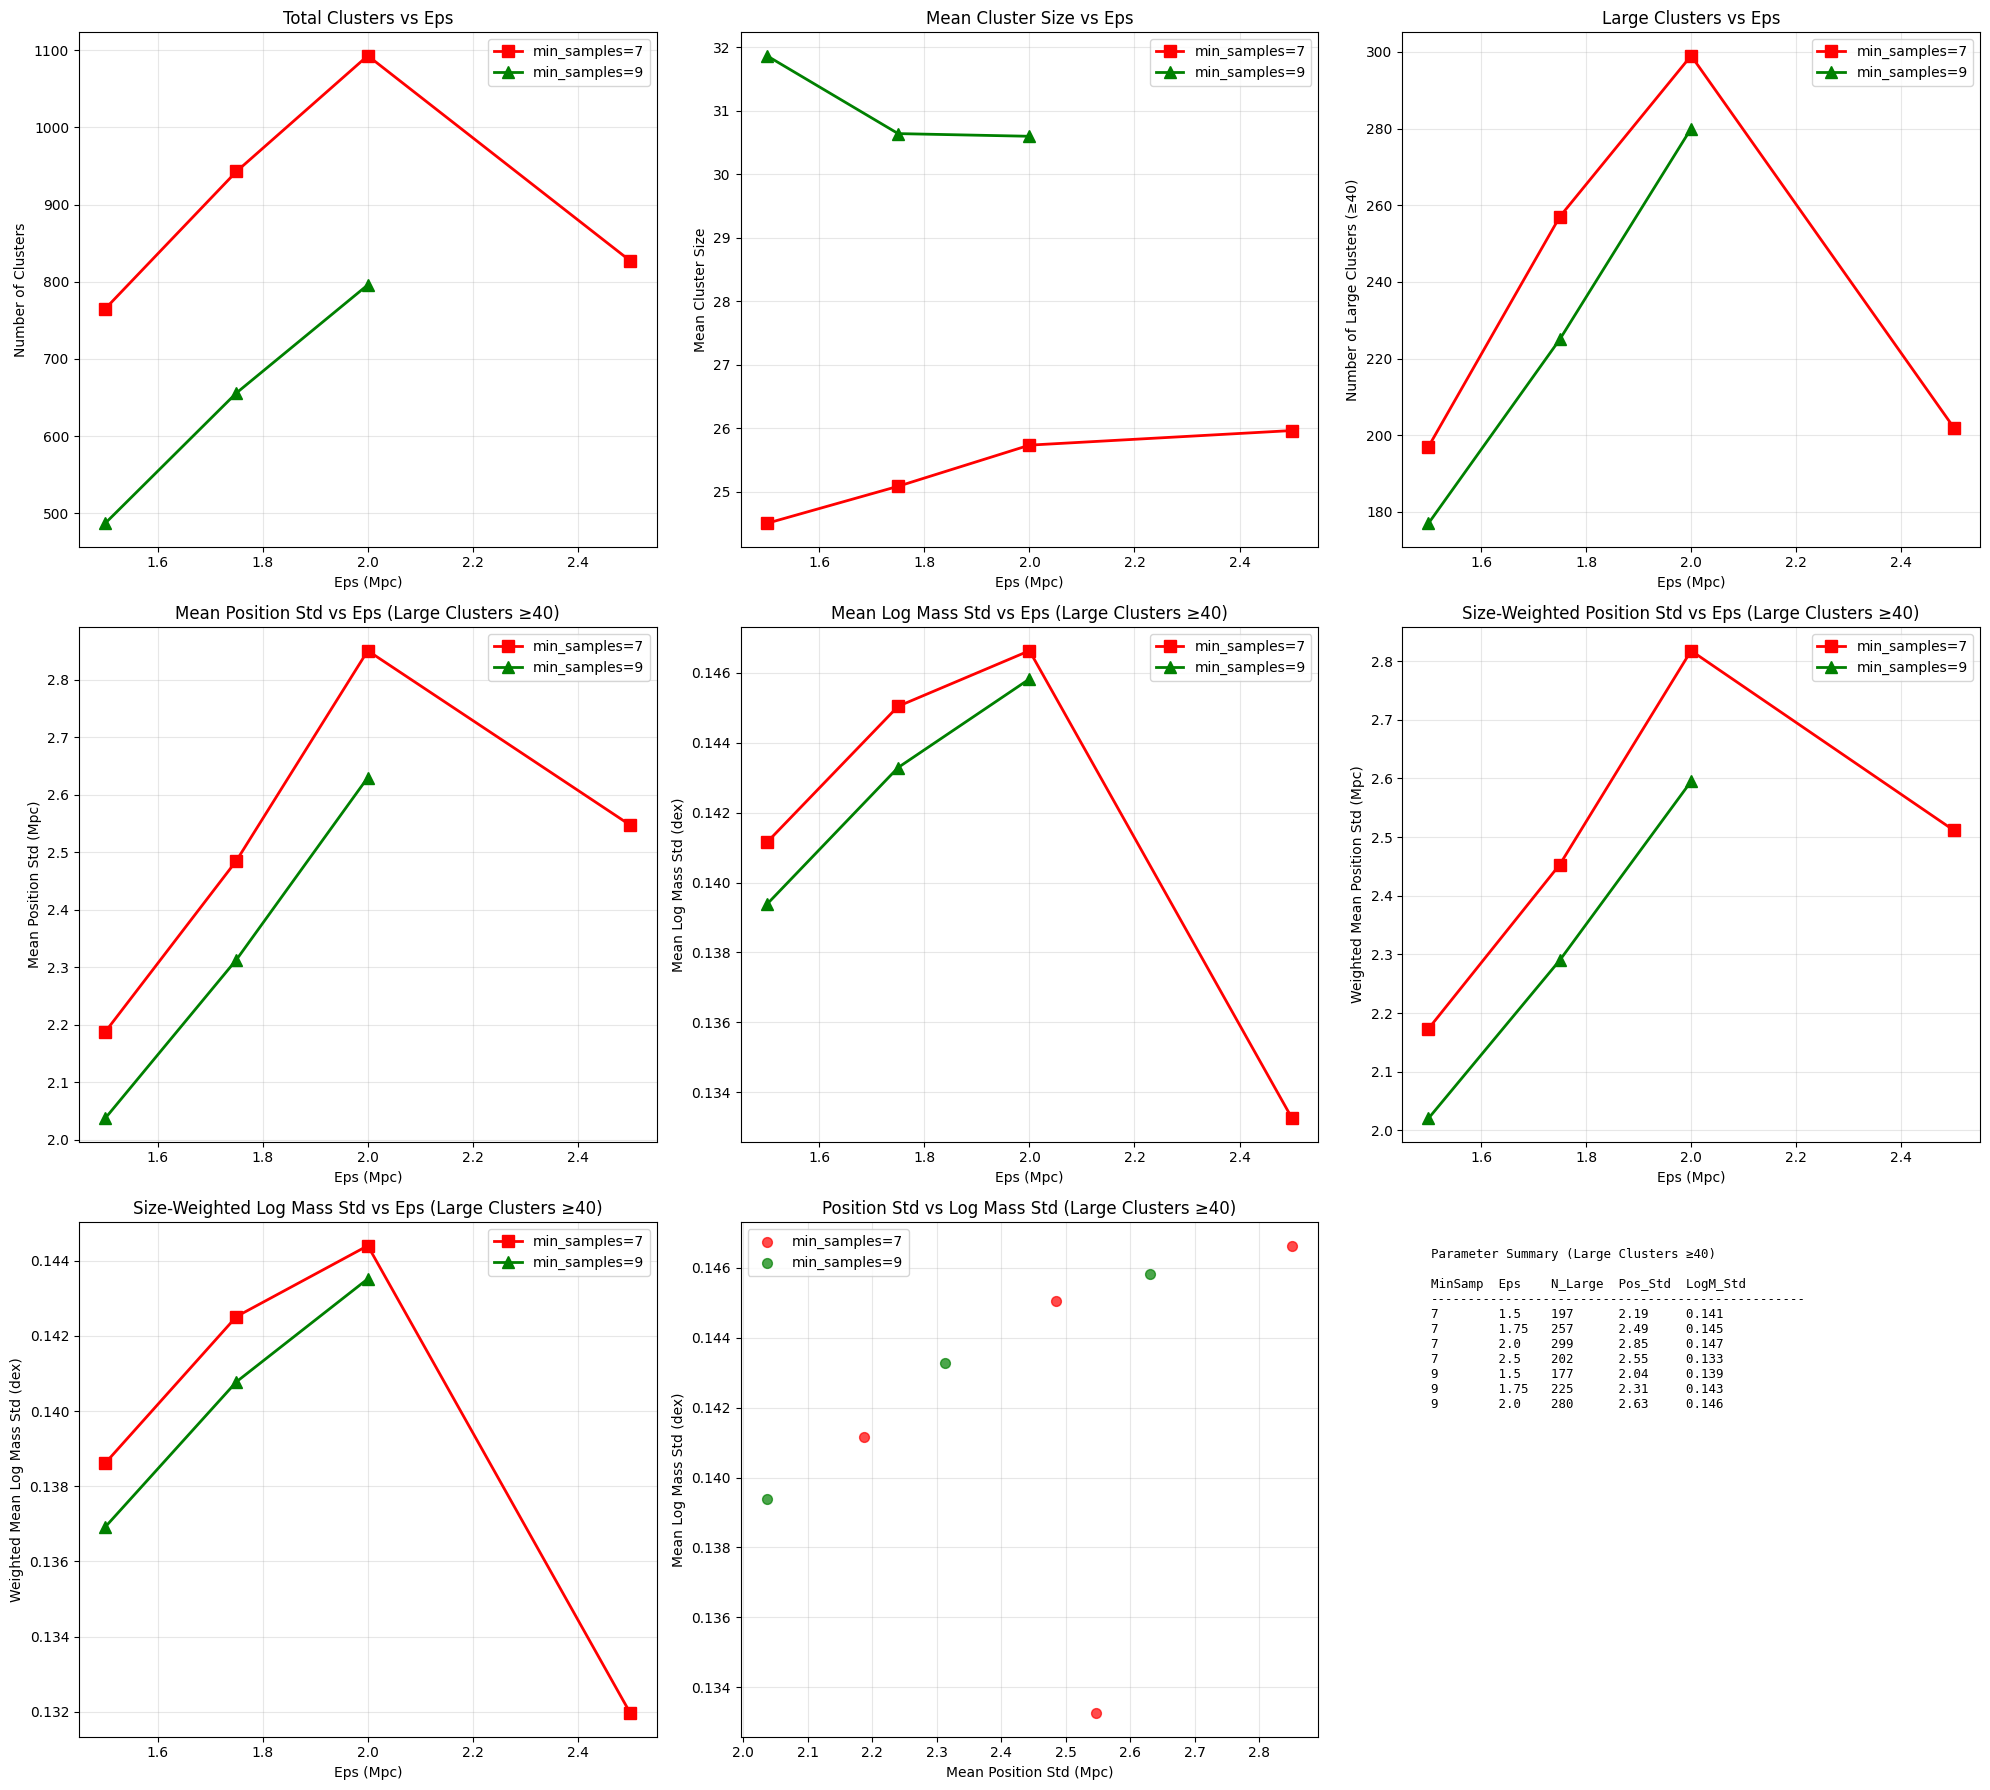


MinSamp  Eps    N_Clust  N_Large  Pos_Std  LogM_Std   Wtd_Pos  Wtd_LogM  
------------------------------------------------------------------------------------------
7        1.5    765      197      2.19     0.141      2.17     0.139     
7        1.75   943      257      2.49     0.145      2.45     0.143     
7        2.0    1093     299      2.85     0.147      2.82     0.144     
7        2.5    827      202      2.55     0.133      2.51     0.132     
9        1.5    487      177      2.04     0.139      2.02     0.137     
9        1.75   656      225      2.31     0.143      2.29     0.141     
9        2.0    796      280      2.63     0.146      2.59     0.144     


In [51]:
# Cell: Enhanced Parameter Analysis Plots Including Position and Mass Std (Large Clusters Only)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

colors = ['blue', 'red', 'green', 'orange', 'purple']
markers = ['o', 's', '^', 'D', 'v']

# Extract data for all min_samples values
plot_data = {}
for i, min_samples in enumerate(min_samples_values):
    plot_data[min_samples] = {
        'valid_eps': [],
        'n_clusters': [],
        'mean_sizes': [],
        'large_clusters': [],
        'mean_position_stds': [],
        'mean_log_mass_stds': [],
        'weighted_position_stds': [],
        'weighted_log_mass_stds': []
    }
    
    for eps in eps_values:
        if eps_min_samples_results[min_samples].get(eps) is not None:
            data = eps_min_samples_results[min_samples][eps]
            plot_data[min_samples]['valid_eps'].append(eps)
            plot_data[min_samples]['n_clusters'].append(data['n_clusters'])
            plot_data[min_samples]['mean_sizes'].append(data['mean_size'])
            plot_data[min_samples]['large_clusters'].append(data['large_clusters'])
            plot_data[min_samples]['mean_position_stds'].append(data['mean_position_std'])
            plot_data[min_samples]['mean_log_mass_stds'].append(data['mean_log_mass_std'])
            plot_data[min_samples]['weighted_position_stds'].append(data['weighted_mean_position_std'])
            plot_data[min_samples]['weighted_log_mass_stds'].append(data['weighted_mean_log_mass_std'])

# Plot 1: Total number of clusters vs eps
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[0].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['n_clusters'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[0].set_xlabel('Eps (Mpc)')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title('Total Clusters vs Eps')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Mean cluster size vs eps
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[1].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['mean_sizes'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[1].set_xlabel('Eps (Mpc)')
axes[1].set_ylabel('Mean Cluster Size')
axes[1].set_title('Mean Cluster Size vs Eps')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Plot 3: Large clusters (size >= 40) vs eps
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[2].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['large_clusters'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[2].set_xlabel('Eps (Mpc)')
axes[2].set_ylabel('Number of Large Clusters (≥40)')
axes[2].set_title('Large Clusters vs Eps')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

# Plot 4: Mean position std vs eps (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[3].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['mean_position_stds'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[3].set_xlabel('Eps (Mpc)')
axes[3].set_ylabel('Mean Position Std (Mpc)')
axes[3].set_title('Mean Position Std vs Eps (Large Clusters ≥40)')
axes[3].grid(True, alpha=0.3)
axes[3].legend()

# Plot 5: Mean log mass std vs eps (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[4].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['mean_log_mass_stds'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[4].set_xlabel('Eps (Mpc)')
axes[4].set_ylabel('Mean Log Mass Std (dex)')
axes[4].set_title('Mean Log Mass Std vs Eps (Large Clusters ≥40)')
axes[4].grid(True, alpha=0.3)
axes[4].legend()

# Plot 6: Size-weighted position std vs eps (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[5].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['weighted_position_stds'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[5].set_xlabel('Eps (Mpc)')
axes[5].set_ylabel('Weighted Mean Position Std (Mpc)')
axes[5].set_title('Size-Weighted Position Std vs Eps (Large Clusters ≥40)')
axes[5].grid(True, alpha=0.3)
axes[5].legend()

# Plot 7: Size-weighted log mass std vs eps (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    if len(plot_data[min_samples]['valid_eps']) > 0:
        axes[6].plot(plot_data[min_samples]['valid_eps'], plot_data[min_samples]['weighted_log_mass_stds'], 
                    color=colors[i], marker=markers[i], linewidth=2, markersize=8, 
                    label=f'min_samples={min_samples}')
axes[6].set_xlabel('Eps (Mpc)')
axes[6].set_ylabel('Weighted Mean Log Mass Std (dex)')
axes[6].set_title('Size-Weighted Log Mass Std vs Eps (Large Clusters ≥40)')
axes[6].grid(True, alpha=0.3)
axes[6].legend()

# Plot 8: Position std vs log mass std scatter (large clusters only)
for i, min_samples in enumerate(min_samples_values):
    for eps in eps_values:
        data = eps_min_samples_results[min_samples].get(eps)
        if data is not None and data['n_large_clusters'] > 0:
            axes[7].scatter(data['mean_position_std'], data['mean_log_mass_std'], 
                          color=colors[i], s=50, alpha=0.7, 
                          label=f'min_samples={min_samples}' if eps == eps_values[0] else "")
axes[7].set_xlabel('Mean Position Std (Mpc)')
axes[7].set_ylabel('Mean Log Mass Std (dex)')
axes[7].set_title('Position Std vs Log Mass Std (Large Clusters ≥40)')
axes[7].grid(True, alpha=0.3)
axes[7].legend()

# Plot 9: Summary table
axes[8].axis('off')
table_text = "Parameter Summary (Large Clusters ≥40)\n\n"
table_text += f"{'MinSamp':<8} {'Eps':<6} {'N_Large':<8} {'Pos_Std':<8} {'LogM_Std':<10}\n"
table_text += "-" * 50 + "\n"

for min_samples in min_samples_values:
    for eps in eps_values:
        data = eps_min_samples_results[min_samples].get(eps)
        if data is not None:
            table_text += f"{min_samples:<8} {eps:<6} {data['large_clusters']:<8} {data['mean_position_std']:<8.2f} {data['mean_log_mass_std']:<10.3f}\n"

axes[8].text(0.05, 0.95, table_text, transform=axes[8].transAxes, fontsize=9, 
             verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

# Print detailed summary
print(f"\n{'MinSamp':<8} {'Eps':<6} {'N_Clust':<8} {'N_Large':<8} {'Pos_Std':<8} {'LogM_Std':<10} {'Wtd_Pos':<8} {'Wtd_LogM':<10}")
print("-" * 90)
for min_samples in min_samples_values:
    for eps in eps_values:
        data = eps_min_samples_results[min_samples].get(eps)
        if data is not None:
            print(f"{min_samples:<8} {eps:<6} {data['n_clusters']:<8} {data['large_clusters']:<8} "
                  f"{data['mean_position_std']:<8.2f} {data['mean_log_mass_std']:<10.3f} "
                  f"{data['weighted_mean_position_std']:<8.2f} {data['weighted_mean_log_mass_std']:<10.3f}")

Reference cluster: ID 27, mass 1.14e+15
Reference centroid: [460.0, 482.0, 470.0]


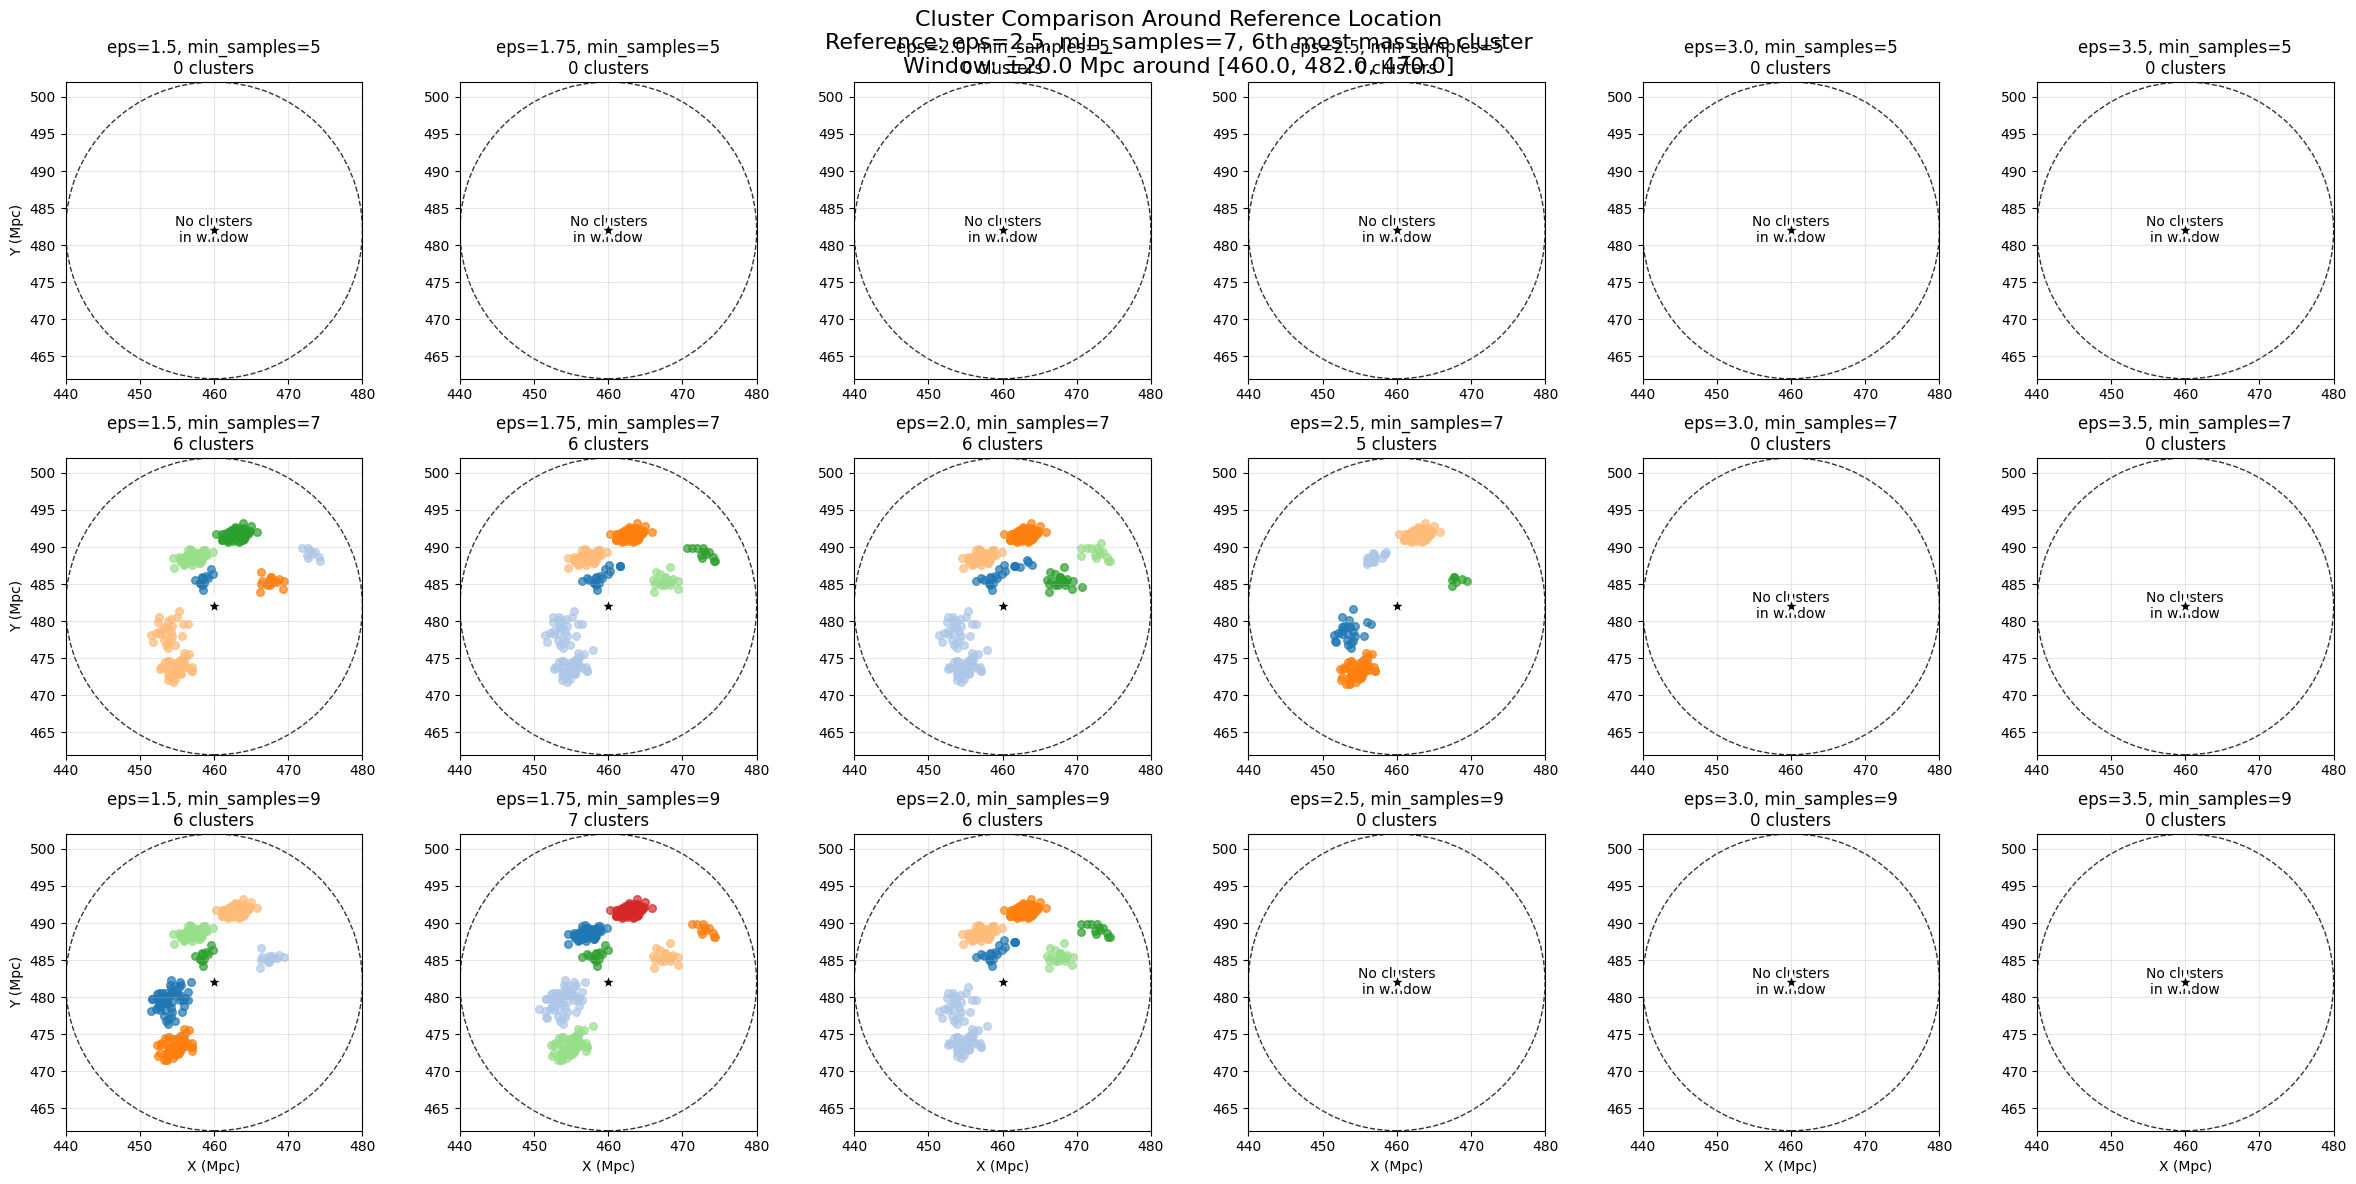

In [52]:
# Notebook Cell: Multi-Parameter Cluster Comparison Around Reference Location (Optimized)
import numpy as np
import matplotlib.pyplot as plt
from backend.utils import load_clusters_from_hdf5, find_clusters_in_window, load_single_cluster_members

# Configuration  
reference_eps = 2.5
reference_min_samples = 7
nth_most_massive = 6  # Select the Nth most massive cluster (1-indexed)
window_size = 20.0  # Mpc radius around centroid

# Load reference cluster data (minimal load to get centroids and masses only)
ref_eps_str = str(reference_eps).replace('.', 'p')
ref_filename = f"clusters_eps_{ref_eps_str}_min_samples_{reference_min_samples}.h5"
ref_clusters, ref_metadata = load_clusters_from_hdf5(config.global_config.output_dir, filename=ref_filename, minimal=True)

# Sort reference clusters by mean mass and select the Nth most massive
ref_clusters_sorted = sorted(ref_clusters, key=lambda x: x['mean_m200_mass'], reverse=True)
if nth_most_massive > len(ref_clusters_sorted):
    print(f"Only {len(ref_clusters_sorted)} clusters available, selecting the most massive")
    reference_cluster = ref_clusters_sorted[0]
else:
    reference_cluster = ref_clusters_sorted[nth_most_massive - 1]

reference_centroid = reference_cluster['mean_position']
reference_centroid = [460, 482, 470]
print(f"Reference cluster: ID {reference_cluster['cluster_id']}, mass {reference_cluster['mean_m200_mass']:.2e}")
print(f"Reference centroid: [{reference_centroid[0]:.1f}, {reference_centroid[1]:.1f}, {reference_centroid[2]:.1f}]")

# Define plot window
x_min, x_max = reference_centroid[0] - window_size, reference_centroid[0] + window_size
y_min, y_max = reference_centroid[1] - window_size, reference_centroid[1] + window_size

# Calculate subplot grid
n_eps = len(eps_values)
n_min_samples = len(min_samples_values)

# Create figure with appropriate size
fig_width = n_eps * 4
fig_height = n_min_samples * 4
fig, axes = plt.subplots(n_min_samples, n_eps, figsize=(fig_width, fig_height))
if n_min_samples == 1:
    axes = axes.reshape(1, -1)
if n_eps == 1:
    axes = axes.reshape(-1, 1)

# Plot for each parameter combination
for row_idx, min_samples in enumerate(min_samples_values):
    for col_idx, eps in enumerate(eps_values):
        ax = axes[row_idx, col_idx]
        
        # Generate filename for this parameter set
        eps_str = str(eps).replace('.', 'p')
        filename = f"clusters_eps_{eps_str}_min_samples_{min_samples}.h5"
        
        try:
            # Find clusters in window (metadata only)
            window_cluster_ids = find_clusters_in_window(config.global_config.output_dir, filename, 
                                                        reference_centroid, window_size)
            
            if len(window_cluster_ids) == 0:
                ax.text(0.5, 0.5, f'No clusters\nin window', 
                       transform=ax.transAxes, ha='center', va='center')
            else:
                # Load individual cluster members
                colors = plt.cm.tab20(np.linspace(0, 1, 20))
                if len(window_cluster_ids) > 20:
                    colors = plt.cm.gist_ncar(np.linspace(0, 1, len(window_cluster_ids)))
                
                for i, cluster_id in enumerate(window_cluster_ids):
                    cluster_data = load_single_cluster_members(config.global_config.output_dir, 
                                                             filename, cluster_id)
                    
                    if cluster_data is not None:
                        positions = cluster_data['member_data']['BoundSubhalo/CentreOfMass']
                        
                        # Filter positions to window
                        mask = ((positions[:, 0] >= x_min) & (positions[:, 0] <= x_max) & 
                               (positions[:, 1] >= y_min) & (positions[:, 1] <= y_max))
                        window_positions = positions[mask]
                        
                        if len(window_positions) > 0:
                            color = colors[i % len(colors)]
                            ax.scatter(window_positions[:, 0], window_positions[:, 1], 
                                     c=[color], s=30, alpha=0.7, 
                                     label=f'ID {cluster_id} (n={cluster_data["cluster_size"]})')
            
            # Mark reference centroid
            ax.scatter(reference_centroid[0], reference_centroid[1], 
                      c='black', s=200, marker='*', 
                      edgecolors='white', linewidth=2, zorder=10)
            
            # Add circle showing window boundary
            circle = plt.Circle((reference_centroid[0], reference_centroid[1]), 
                               window_size, fill=False, color='black', 
                               linestyle='--', linewidth=1, alpha=0.8)
            ax.add_patch(circle)
            
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
            ax.set_title(f'eps={eps}, min_samples={min_samples}\n{len(window_cluster_ids)} clusters')
            
            if row_idx == n_min_samples - 1:
                ax.set_xlabel('X (Mpc)')
            if col_idx == 0:
                ax.set_ylabel('Y (Mpc)')
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\neps={eps}\nmin_samples={min_samples}', 
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_aspect('equal')

plt.suptitle(f'Cluster Comparison Around Reference Location\n'
             f'Reference: eps={reference_eps}, min_samples={reference_min_samples}, '
             f'{nth_most_massive}{"st" if nth_most_massive==1 else "nd" if nth_most_massive==2 else "rd" if nth_most_massive==3 else "th"} most massive cluster\n'
             f'Window: ±{window_size} Mpc around [{reference_centroid[0]:.1f}, {reference_centroid[1]:.1f}, {reference_centroid[2]:.1f}]',
             fontsize=16, y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Load haloes

In [78]:
eps = 1.75
min_samples = 9

# Convert eps to filename format (2.5 -> "2p5")
eps_str = str(eps).replace('.', 'p')
filename = f"clusters_eps_{eps_str}_min_samples_{min_samples}.h5"

clusters, cluster_metadata = load_clusters_from_hdf5(config.global_config.output_dir, filename=filename,
                                                    minimal=False)
print(f"Successfully loaded {len(clusters)} clusters")
clusters_available = True

# Check for traces file existence without loading data
trace_filename = f"halo_traces_eps_{eps_str}_min_samples_{min_samples}.h5"

try:
    trace_filepath = os.path.join(config.global_config.output_dir, trace_filename)
    if os.path.exists(trace_filepath):
        print("Halo trace file found")
        traces_available = True
    else:
        print("No halo trace data found. Run Mode 2 for temporal evolution plots.")
        traces_available = False
except Exception:
    print("No halo trace data found. Run Mode 2 for temporal evolution plots.")
    traces_available = False

Successfully loaded 656 clusters
Halo trace file found


In [79]:
# Cell 4: Data Summary Statistics
if clusters_available:
    cluster_sizes = [c['cluster_size'] for c in clusters]
    
    print("Cluster Statistics:")
    print(f"  Total clusters: {len(clusters)}")
    print(f"  Largest cluster size: {max(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Mean cluster size: {np.mean(cluster_sizes):.2f}")
    print(f"  Median cluster size: {np.median(cluster_sizes):.2f}")
    
    print(f"\nTop 5 clusters by size:")
    sorted_clusters = sorted(clusters, key=lambda x: x['cluster_size'], reverse=True)
    for i, cluster in enumerate(sorted_clusters[:5]):
        print(f"  {i+1}. Cluster {cluster['cluster_id']}: {cluster['cluster_size']} members, "
              f"mass={cluster['mean_m200_mass']:.2e}")

if traces_available:
    cluster_trace_counts = get_cluster_trace_info(config.global_config.output_dir, filename=trace_filename)
    total_traced_haloes = sum(cluster_trace_counts.values())
    
    print(f"\nTrace Statistics:")
    print(f"  Total traced haloes: {total_traced_haloes}")
    print(f"  Clusters with traces: {len(cluster_trace_counts)}")

Cluster Statistics:
  Total clusters: 656
  Largest cluster size: 80
  Mean cluster size: 30.64
  Median cluster size: 22.00

Top 5 clusters by size:
  1. Cluster 106: 80 members, mass=3.24e+14
  2. Cluster 128: 80 members, mass=3.22e+14
  3. Cluster 168: 80 members, mass=1.27e+15
  4. Cluster 40: 80 members, mass=7.69e+14
  5. Cluster 82: 80 members, mass=1.16e+15

Trace Statistics:
  Total traced haloes: 13423
  Clusters with traces: 225


# Cluster sizes

## Cluster sizes in random region

In [55]:
# empirical_null_analysis.py
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Load cluster sizes from HDF5 file
with h5py.File('output/random_control_clusters.h5', 'r') as f:
    cluster_sizes = []
    clusters_grp = f['clusters']
    for cluster_name in clusters_grp.keys():
        cluster_sizes.append(clusters_grp[cluster_name].attrs['cluster_size'])

cluster_sizes = np.array(cluster_sizes)

# Empirical survival function: P(size >= n)
def empirical_survival(n):
    return np.mean(cluster_sizes >= n)

# Calculate significance thresholds
size_range = np.arange(3, max(cluster_sizes) + 1)
survival_probs = [empirical_survival(n) for n in size_range]

# Find thresholds for different significance levels
alpha_levels = [0.1, 0.05, 0.01, 0.001]
thresholds = {}

for alpha in alpha_levels:
    threshold_candidates = [n for n, p in zip(size_range, survival_probs) if p <= alpha]
    if threshold_candidates:
        thresholds[alpha] = min(threshold_candidates)
    else:
        thresholds[alpha] = None

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Empirical distribution (linear scale)
bins = np.arange(1, max(cluster_sizes) + 2) - 0.5
counts, _ = np.histogram(cluster_sizes, bins=bins, density=True)
bin_centers = np.arange(1, max(cluster_sizes) + 1)

ax1.bar(bin_centers, counts, alpha=0.7, edgecolor='black', width=0.8)
ax1.set_xlabel('Cluster Size')
ax1.set_ylabel('Probability Density')
ax1.set_title(f'Empirical Null Distribution (N={len(cluster_sizes)})')
ax1.grid(True, alpha=0.3)

# Add threshold lines
colors = ['orange', 'red', 'purple', 'black']
for i, (alpha, threshold) in enumerate(thresholds.items()):
    if threshold is not None:
        ax1.axvline(threshold, color=colors[i], linestyle='--', 
                   label=f'{(1-alpha)*100:.1f}% threshold: {threshold}')
ax1.legend()

# 2. Empirical distribution (log scale)
ax2.bar(bin_centers, counts, alpha=0.7, edgecolor='black', width=0.8)
ax2.set_xlabel('Cluster Size')
ax2.set_ylabel('Probability Density')
ax2.set_title('Empirical Null Distribution (Log Scale)')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Add threshold lines
for i, (alpha, threshold) in enumerate(thresholds.items()):
    if threshold is not None:
        ax2.axvline(threshold, color=colors[i], linestyle='--', 
                   label=f'{(1-alpha)*100:.1f}% threshold: {threshold}')
ax2.legend()

# 3. Survival function (linear scale)
ax3.plot(size_range, survival_probs, 'bo-', markersize=4, linewidth=2)
ax3.set_xlabel('Cluster Size')
ax3.set_ylabel('P(Size ≥ n)')
ax3.set_title('Empirical Survival Function')
ax3.grid(True, alpha=0.3)

# Add significance levels
for i, alpha in enumerate(alpha_levels):
    ax3.axhline(alpha, color=colors[i], linestyle='--', alpha=0.7,
               label=f'α = {alpha}')
    if thresholds[alpha] is not None:
        ax3.plot(thresholds[alpha], alpha, 'o', color=colors[i], markersize=8)

ax3.legend()
ax3.set_ylim(0, 1)

# 4. Survival function (log scale)
ax4.plot(size_range, survival_probs, 'bo-', markersize=4, linewidth=2)
ax4.set_xlabel('Cluster Size')
ax4.set_ylabel('P(Size ≥ n)')
ax4.set_title('Empirical Survival Function (Log Scale)')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

# Add significance levels
for i, alpha in enumerate(alpha_levels):
    ax4.axhline(alpha, color=colors[i], linestyle='--', alpha=0.7,
               label=f'α = {alpha}')
    if thresholds[alpha] is not None:
        ax4.plot(thresholds[alpha], alpha, 'o', color=colors[i], markersize=8)

ax4.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Null Distribution Summary:")
print(f"Total clusters: {len(cluster_sizes)}")
print(f"Size range: {min(cluster_sizes)} - {max(cluster_sizes)}")
print(f"Mean size: {np.mean(cluster_sizes):.2f}")
print(f"Median size: {np.median(cluster_sizes):.2f}")

print(f"\nSignificance Thresholds:")
for alpha in alpha_levels:
    if thresholds[alpha] is not None:
        confidence = (1 - alpha) * 100
        n_expected = empirical_survival(thresholds[alpha]) * len(cluster_sizes)
        print(f"{confidence:5.1f}% confidence (α={alpha:5.3f}): size ≥ {thresholds[alpha]:2d} "
              f"(p={empirical_survival(thresholds[alpha]):.4f}, {n_expected:.1f} expected)")
    else:
        print(f"{(1-alpha)*100:5.1f}% confidence (α={alpha:5.3f}): No threshold found")

# Detailed tail probabilities
print(f"\nTail Probabilities:")
for size in range(10, min(30, max(cluster_sizes) + 1), 5):
    prob = empirical_survival(size)
    expected = prob * len(cluster_sizes)
    print(f"P(size ≥ {size:2d}) = {prob:.4f} ({expected:.1f} expected)")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'output/random_control_clusters.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Cluster sizes from constrained region

In [ ]:
# Cell: Cluster Size Distribution
if clusters_available and len(clusters) > 0:
    cluster_sizes = [cluster['cluster_size'] for cluster in clusters]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Linear scale histogram
    ax1.hist(cluster_sizes, bins=range(1, max(cluster_sizes) + 2), alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Cluster Size', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title(f'Cluster Size Distribution (Linear)\nTotal Clusters: {len(clusters)}', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Log scale histogram
    ax2.hist(cluster_sizes, bins=range(1, max(cluster_sizes) + 2), alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Cluster Size', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Cluster Size Distribution (Log Scale)', fontsize=14)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Cluster size statistics:")
    print(f"  Total clusters: {len(cluster_sizes)}")
    print(f"  Mean size: {np.mean(cluster_sizes):.2f}")
    print(f"  Median size: {np.median(cluster_sizes):.2f}")
    print(f"  Min size: {min(cluster_sizes)}")
    print(f"  Max size: {max(cluster_sizes)}")
    print(f"  Standard deviation: {np.std(cluster_sizes):.2f}")

# Plot cluster locations (overview)

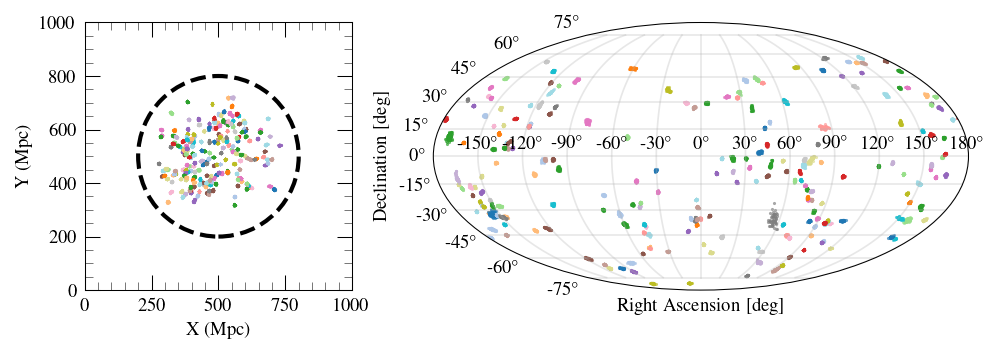

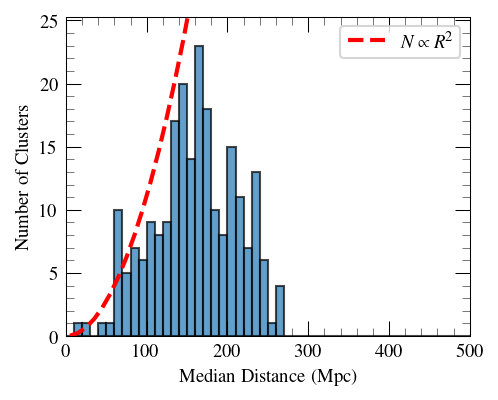

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import random

min_members_plot = 40

if clusters_available:
    with plt.style.context(get_mplstyle_path(mnras_style)):
        significant_clusters = [h for h in clusters if h['cluster_size'] >= min_members_plot]
        if len(significant_clusters) == 0:
            print(f"No clusters found with at least {min_members_plot} members")
        else:
            # ---- FIRST FIGURE: 2D XY and Mollweide projections ----
            fig = plt.figure(figsize=(6.5, 3.15))
            gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

            ax1 = fig.add_subplot(gs[0, 0])
            ax2 = fig.add_subplot(gs[0, 1], projection='mollweide')

            tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
            random.seed(42)
            assigned_colors = random.choices(tab20_colors, k=len(significant_clusters))

            for i, cluster in enumerate(significant_clusters):
                positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
                color = assigned_colors[i]
                ax1.scatter(positions[:, 0], positions[:, 1], c=[color], s=1, alpha=0.7, marker=".")

                # Mollweide expects longitude (ra) in [-pi, pi] and latitude (dec) in radians
                ra = np.asarray(cluster['member_data']['ra'])
                dec = np.asarray(cluster['member_data']['dec'])
                ra_wrapped = np.where(ra > 180, ra - 360, ra)  # wrap to [-180, 180]
                ra_rad = np.radians(ra_wrapped)
                dec_rad = np.radians(dec)
                ax2.scatter(ra_rad, dec_rad, c=[color], s=1, alpha=0.7, marker=".")

            # 2D plot formatting
            ax1.set_xlabel('X (Mpc)')
            ax1.set_ylabel('Y (Mpc)')
            ax1.set_ylim(0,1000)
            ax1.set_xlim(0,1000)
            circle = plt.Circle((500, 500), 300, fill=False, color='black', linestyle='--', linewidth=2)
            ax1.add_patch(circle)
            ax1.set_aspect('equal')

            # Mollweide formatting
            ax2.grid(True, alpha=0.3)
            # Set xticks in radians for Mollweide, with labels in degrees
            tick_labels = np.arange(-150, 181, 30)
            ax2.set_xticks(np.radians(tick_labels))
            ax2.set_xticklabels([f"{tl}°" for tl in tick_labels])
            ax2.set_xlabel('Right Ascension [deg]')
            ax2.set_ylabel('Declination [deg]')

            plt.tight_layout(pad=0.1)
            plt.savefig("./plots/posterior_positions.pdf")
            plt.show()
            
            # ---- SECOND FIGURE: Histogram of Median Distances ----
            significant_median_distances = [
                np.median(cluster['member_data']['dist'])
                for cluster in significant_clusters
            ]
            fig, ax = plt.subplots(figsize=(3.15, 2.5))
            n, bins, patches = ax.hist(significant_median_distances, bins=np.arange(0,510,10),
                                       alpha=0.7, edgecolor='black')
            bin_centers = (bins[:-1] + bins[1:]) / 2
            r_squared_line = bin_centers**2
            scaling_factor = 1./900
            r_squared_line *= scaling_factor
            ax.plot(bin_centers, r_squared_line, 'r--', linewidth=2, label=r'$N \propto R^2$')
            ax.set_xlabel('Median Distance (Mpc)')
            ax.set_ylabel('Number of Clusters')
            ax.set_ylim(0, 1.1 * np.max(n))
            ax.legend()
            plt.tight_layout(pad=0.1)
            plt.savefig("./plots/median_distances.pdf")
            plt.show()


# Helper plot functions

In [56]:
# Cell 6: Cluster Diagnostic Function
def plot_cluster_diagnostic(cluster_id=None, coordinates=None):
   # If coordinates are provided, use them directly
   if coordinates is not None:
       target_cluster_center = np.array(coordinates)
       target_cluster_id = "Custom"
       cluster_type = "Custom"
       target_cluster = {
           'cluster_size': 'N/A',
           'mean_mass': 'N/A',
           'mass_std': 'N/A'
       }
   else:
       # Original cluster-based logic
       if not clusters_available or len(clusters) == 0:
           print("No clusters available for diagnostic plot")
           return
       
       # Find target cluster
       if cluster_id is None:
           target_cluster = max(clusters, key=lambda x: x['cluster_size'])
           cluster_type = "Largest"
       else:
           target_cluster = None
           for cluster in clusters:
               if cluster['cluster_id'] == cluster_id:
                   target_cluster = cluster
                   break
           
           if target_cluster is None:
               print(f"Cluster ID {cluster_id} not found")
               return
           cluster_type = "Selected"
       
       target_cluster_center = target_cluster['mean_position']
       target_cluster_id = target_cluster['cluster_id']
   
   # Get all positions for plotting context
   if coordinates is None:
       all_positions = []
       all_cluster_ids = []
       
       for cluster in clusters:
           positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
           cluster_id_val = cluster['cluster_id']
           all_positions.extend(positions)
           all_cluster_ids.extend([cluster_id_val] * len(positions))
       
       all_positions = np.array(all_positions)
       all_cluster_ids = np.array(all_cluster_ids)
       
       distances = np.linalg.norm(all_positions - target_cluster_center, axis=1)
       within_15mpc = distances <= 15.0
       
       nearby_positions = all_positions[within_15mpc]
       nearby_cluster_labels = all_cluster_ids[within_15mpc]
   else:
       # For custom coordinates, we still need existing cluster data for context
       if not clusters_available or len(clusters) == 0:
           # If no clusters exist, create empty arrays for plotting
           nearby_positions = np.array([]).reshape(0, 3)
           nearby_cluster_labels = np.array([])
       else:
           all_positions = []
           all_cluster_ids = []
           
           for cluster in clusters:
               positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
               cluster_id_val = cluster['cluster_id']
               all_positions.extend(positions)
               all_cluster_ids.extend([cluster_id_val] * len(positions))
           
           all_positions = np.array(all_positions)
           all_cluster_ids = np.array(all_cluster_ids)
           
           distances = np.linalg.norm(all_positions - target_cluster_center, axis=1)
           within_15mpc = distances <= 15.0
           
           nearby_positions = all_positions[within_15mpc]
           nearby_cluster_labels = all_cluster_ids[within_15mpc]
   
   fig, axes = plt.subplots(1, 3, figsize=(18, 6))
   
   if len(nearby_cluster_labels) > 0:
       unique_labels = np.unique(nearby_cluster_labels)
       colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
   else:
       unique_labels = []
       colors = []
   
   projections = [
       (0, 1, 'X', 'Y', 'X-Y'),
       (0, 2, 'X', 'Z', 'X-Z'), 
       (1, 2, 'Y', 'Z', 'Y-Z')
   ]
   
   for ax_idx, (dim1, dim2, label1, label2, proj_name) in enumerate(projections):
       ax = axes[ax_idx]
       
       # Plot existing clusters if any
       for i, label in enumerate(unique_labels):
           mask = nearby_cluster_labels == label
           if coordinates is None and label == target_cluster_id:
               ax.scatter(nearby_positions[mask, dim1], nearby_positions[mask, dim2], 
                         c='gray', s=80, alpha=0.8, label=f'{cluster_type} Cluster (ID {label})', edgecolors='darkred')
           else:
               ax.scatter(nearby_positions[mask, dim1], nearby_positions[mask, dim2], 
                         c=[colors[i]], s=40, alpha=0.6, label=f'Cluster {label}')
       
       # Plot the target center (cluster center or custom coordinates)
       center_label = 'Custom Center' if coordinates is not None else 'Cluster Center'
       ax.scatter(target_cluster_center[dim1], target_cluster_center[dim2], 
                 c='black', s=300, marker='*', label=center_label, edgecolors='white', linewidth=2)
       
       circle = plt.Circle((target_cluster_center[dim1], target_cluster_center[dim2]), 
                          7.5, fill=False, color='black', linestyle='--', linewidth=2, 
                          label='7.5 Mpc (eps threshold)')
       ax.add_patch(circle)
       
       ax.set_xlabel(f'{label1} (Mpc)')
       ax.set_ylabel(f'{label2} (Mpc)')
       ax.set_title(f'{proj_name} projection')
       ax.set_aspect('equal')
       
       if ax_idx == 0:
           ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   
   if coordinates is not None:
       fig.suptitle(f'Haloes within 15 Mpc of Custom Coordinates\n'
                   f'Center: [{target_cluster_center[0]:.1f}, {target_cluster_center[1]:.1f}, {target_cluster_center[2]:.1f}]', 
                   fontsize=14)
       
       print(f"Custom coordinates analysis:")
       print(f"  Center: [{target_cluster_center[0]:.1f}, {target_cluster_center[1]:.1f}, {target_cluster_center[2]:.1f}]")
   else:
       fig.suptitle(f'Haloes within 15 Mpc of {cluster_type} Cluster\n'
                   f'Cluster Size: {target_cluster["cluster_size"]}, ID: {target_cluster_id}', 
                   fontsize=14)
       
       print(f"{cluster_type} cluster analysis:")
       print(f"  Cluster ID: {target_cluster_id}")
       print(f"  Size: {target_cluster['cluster_size']} members")
       print(f"  Center: [{target_cluster_center[0]:.1f}, {target_cluster_center[1]:.1f}, {target_cluster_center[2]:.1f}]")
       print(f"  Mean m200 mass: {target_cluster['mean_m200_mass']:.2e}")
       print(f"  Mass m200 std: {target_cluster['m200_mass_std']:.2e}")
   
   plt.tight_layout()
   plt.show()

In [88]:
# Cell 8a: Single Cluster Trajectory Plot Function
def plot_cluster_trajectory(cluster_id, ax=None):
    traces = load_single_cluster_traces(cluster_id, config.global_config.output_dir, filename=trace_filename)
    
    if traces is None:
        print(f"No traces available for cluster {cluster_id}")
        return None
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        standalone = True
    else:
        standalone = False
    
    # Calculate cluster centroid from final positions (snapshot 77)
    final_positions = []
    final_masses = []
    for trace_data in traces:
        positions = trace_data['BoundSubhalo/CentreOfMass']
        masses = trace_data['BoundSubhalo/TotalMass']
        snapshots = trace_data['snapshots']
        final_idx = np.where(snapshots == 77)[0]
        if len(final_idx) > 0:
            final_positions.append(positions[final_idx[0]])
            final_masses.append(masses[final_idx[0]])
    
    if len(final_positions) > 0:
        final_positions = np.array(final_positions)
        cluster_centroid = np.mean(final_positions, axis=0)
        total_final_mass = np.mean(final_masses)
    else:
        cluster_centroid = np.array([0, 0, 0])
        total_final_mass = 0
    
    # Generate colors for each trajectory
    colors = plt.cm.tab20(np.linspace(0, 1, min(20, len(traces))))
    if len(traces) > 20:
        colors = plt.cm.gist_ncar(np.linspace(0, 1, len(traces)))
    
    for i, trace_data in enumerate(traces):
        positions = trace_data['BoundSubhalo/CentreOfMass']
        snapshots = trace_data['snapshots']
        
        # Plot trajectory line
        ax.plot(positions[:, 0], positions[:, 1], '-', 
               alpha=0.5, linewidth=0.8, color=colors[i])
        
        # Plot start and end points with smaller sizes
        ax.scatter(positions[0, 0], positions[0, 1], 
                  c='red', s=8, marker='s', alpha=0.9, 
                  edgecolors='darkred', linewidth=0.3, zorder=10)
        ax.scatter(positions[-1, 0], positions[-1, 1], 
                  c='blue', s=8, marker='o', alpha=0.9,
                  edgecolors='darkblue', linewidth=0.3, zorder=10)
    
    # Add radial rings at 10 and 20 Mpc
    circle_10 = plt.Circle((cluster_centroid[0], cluster_centroid[1]), 
                          10, fill=False, color='gray', linestyle='--', 
                          linewidth=1, alpha=0.7)
    circle_20 = plt.Circle((cluster_centroid[0], cluster_centroid[1]), 
                          20, fill=False, color='gray', linestyle=':', 
                          linewidth=1, alpha=0.7)
    ax.add_patch(circle_10)
    ax.add_patch(circle_20)
    
    # Set axis limits to +/- 15 Mpc from cluster centroid
    ax.set_xlim(cluster_centroid[0] - 15, cluster_centroid[0] + 15)
    ax.set_ylim(cluster_centroid[1] - 15, cluster_centroid[1] + 15)
    
    # Add text box with cluster information in lower left corner
    info_text = f'Cluster {cluster_id} (n={len(traces)})\nMass: {total_final_mass:.2e}' + r' M$_{\odot}$'
    ax.text(0.05, 0.05, info_text, transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
            verticalalignment='bottom')
    
    ax.set_xlabel('X (Mpc)', fontsize=10)
    ax.set_ylabel('Y (Mpc)', fontsize=10)
    ax.set_aspect('equal')
    ax.set_facecolor('#f8f8f8')
    ax.tick_params(labelsize=8)
    
    if standalone:
        plt.tight_layout()
        plt.show()
    
    return traces

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cluster_mass_evolution(cluster_id, ax=None):
    """
    Plot the median and 10th–90th percentile range of BoundSubhalo/TotalMass
    as a function of snapshot for all haloes in the given cluster.
    
    Parameters
    ----------
    cluster_id : int or str
        Identifier of the cluster to load.
    ax : matplotlib.axes.Axes, optional
        Axes in which to plot. If None, creates a new figure + axes.

    Returns
    -------
    None
    """
    # Load all traces for this cluster
    traces = load_single_cluster_traces(cluster_id, config.global_config.output_dir, filename=trace_filename)
    if traces is None or len(traces) == 0:
        print(f"No traces available for cluster {cluster_id}")
        return

    # Gather all unique snapshot indices present
    all_snaps = np.unique(np.concatenate([t['snapshots'] for t in traces]))
    all_snaps.sort()

    # For each snapshot, collect the masses from each trace (where available)
    medians = []
    p10 = []
    p90 = []

    for snap in all_snaps:
        masses_at_snap = []
        for t in traces:
            # find if this trace has the snapshot
            idx = np.where(t['snapshots'] == snap)[0]
            if idx.size > 0:
                masses_at_snap.append(t['BoundSubhalo/TotalMass'][idx[0]])
        if len(masses_at_snap) > 0:
            arr = np.array(masses_at_snap)
            p10.append(np.percentile(arr, 10))
            medians.append(np.percentile(arr, 50))
            p90.append(np.percentile(arr, 90))
        else:
            # no data for this snapshot
            p10.append(np.nan)
            medians.append(np.nan)
            p90.append(np.nan)

    # Prepare the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        standalone = True
    else:
        standalone = False

    # Convert lists to arrays
    all_snaps = np.array(all_snaps)
    p10 = np.array(p10)
    medians = np.array(medians)
    p90 = np.array(p90)

    # Plot median line
    ax.plot(all_snaps, medians, '-', lw=2, label='Median Mass', color='C0')

    # Shade 10th–90th percentile range
    ax.fill_between(all_snaps, p10, p90, color='C0', alpha=0.3,
                    label='10th–90th percentile')

    # Labels & styling
    ax.set_xlabel('Snapshot', fontsize=12)
    ax.set_ylabel('BoundSubhalo / TotalMass', fontsize=12)
    ax.set_title(f'Cluster {cluster_id}: Mass Evolution (n={len(traces)})', pad=10)
    ax.grid(True, alpha=0.2)
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=10)

    if standalone:
        plt.tight_layout()
        plt.show()


In [59]:
# Cell: Single Cluster Mass Distribution Function
def plot_cluster_mass_distribution(cluster_id, ax=None):
    if not clusters_available:
        print(f"No clusters available")
        return
    
    # Find the cluster
    target_cluster = None
    for cluster in clusters:
        if cluster['cluster_id'] == cluster_id:
            target_cluster = cluster
            break
    
    if target_cluster is None:
        print(f"Cluster ID {cluster_id} not found")
        return
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        standalone = True
    else:
        standalone = False
    
    cluster_masses = target_cluster['member_data']['BoundSubhalo/TotalMass']
    cluster_size = target_cluster['cluster_size']
    median_mass = np.median(cluster_masses)
    mean_mass = target_cluster['mean_m200_mass']
    
    # Plot histogram of masses
    ax.hist(cluster_masses, bins=10**np.arange(13.,16,0.05), alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for mean and median
    ax.axvline(mean_mass, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: {mean_mass:.2e}')
    ax.axvline(median_mass, color='orange', linestyle='-', linewidth=2, alpha=0.8, label=f'Median: {median_mass:.2e}')
    
    ax.set_xlabel('M200 Mass (M☉)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Cluster {cluster_id} (n={cluster_size})', fontsize=12, pad=10)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3, linewidth=0.5)
    ax.set_xscale("log")
    ax.legend(fontsize=8)
    
    if standalone:
        plt.tight_layout()
        plt.show()

# Cluster evolutions

In [80]:
# Cell 7: Temporal Evolution Setup
if traces_available:
    cluster_trace_counts = get_cluster_trace_info(config.global_config.output_dir, filename=trace_filename)
    
    # Filter clusters with sufficient traces
    min_traces_for_plot = 5  # Adjustable parameter
    significant_trace_clusters = {k: v for k, v in cluster_trace_counts.items() 
                                 if v >= min_traces_for_plot}
    
    print(f"Temporal evolution setup:")
    print(f"  Total clusters with traces: {len(cluster_trace_counts)}")
    print(f"  Clusters with >= {min_traces_for_plot} traces: {len(significant_trace_clusters)}")
    
    # Sort by number of traces
    sorted_trace_clusters = sorted(significant_trace_clusters.items(), 
                                  key=lambda x: x[1], reverse=True)
    
    print(f"\nTop clusters by trace count:")
    for cluster_id, trace_count in sorted_trace_clusters[:10]:
        print(f"  Cluster {cluster_id}: {trace_count} traces")

Temporal evolution setup:
  Total clusters with traces: 225
  Clusters with >= 5 traces: 225

Top clusters by trace count:
  Cluster 40: 80 traces
  Cluster 82: 80 traces
  Cluster 93: 80 traces
  Cluster 106: 80 traces
  Cluster 128: 80 traces
  Cluster 168: 80 traces
  Cluster 99: 79 traces
  Cluster 174: 79 traces
  Cluster 193: 79 traces
  Cluster 45: 78 traces


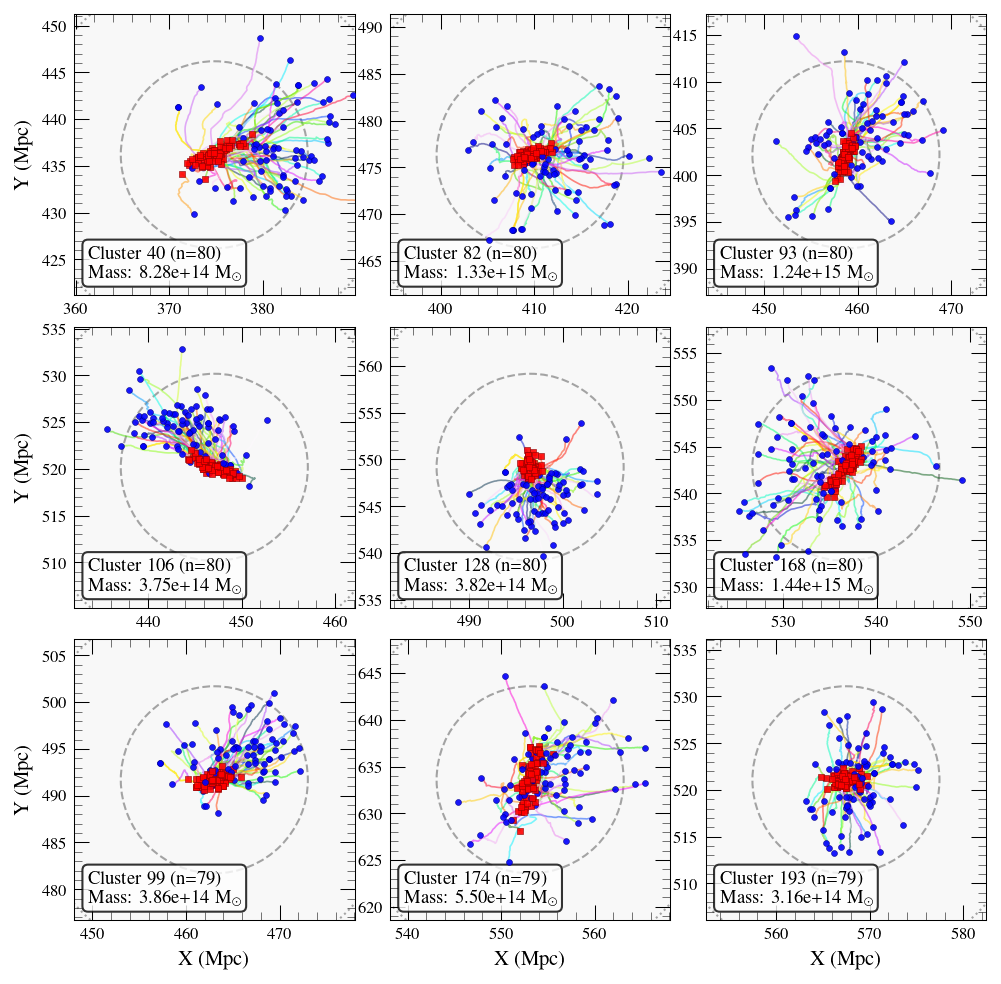

In [90]:
# Cell 8b: Top 9 Cluster Trajectory Plots (3x3 Grid)
if traces_available and len(significant_trace_clusters) > 0:
    # Plot top 9 clusters in 3x3 grid
    with plt.style.context(get_mplstyle_path(mnras_style)):
        n_clusters_to_plot = min(9, len(sorted_trace_clusters))
        fig, axes = plt.subplots(3, 3, figsize=(6.5, 6.5))
        axes = axes.flatten()
        
        for plot_idx in range(n_clusters_to_plot):
            cluster_id, trace_count = sorted_trace_clusters[plot_idx]
            ax = axes[plot_idx]
            plot_cluster_trajectory(cluster_id, ax=ax)
        
        # Hide unused subplots
        for plot_idx in range(n_clusters_to_plot, 9):
            axes[plot_idx].set_visible(False)

        # Hide axis labels
        for plot_idx in range(n_clusters_to_plot):
            ax = axes[plot_idx]
            if plot_idx not in [6,7,8]:
                ax.set_xlabel("")
            if plot_idx not in [0,3,6]:
                ax.set_ylabel("")
                
        plt.tight_layout(pad=0.1)
        plt.savefig("./plots/cluster_evolutions.pdf")
        plt.show()

# Mass distributions

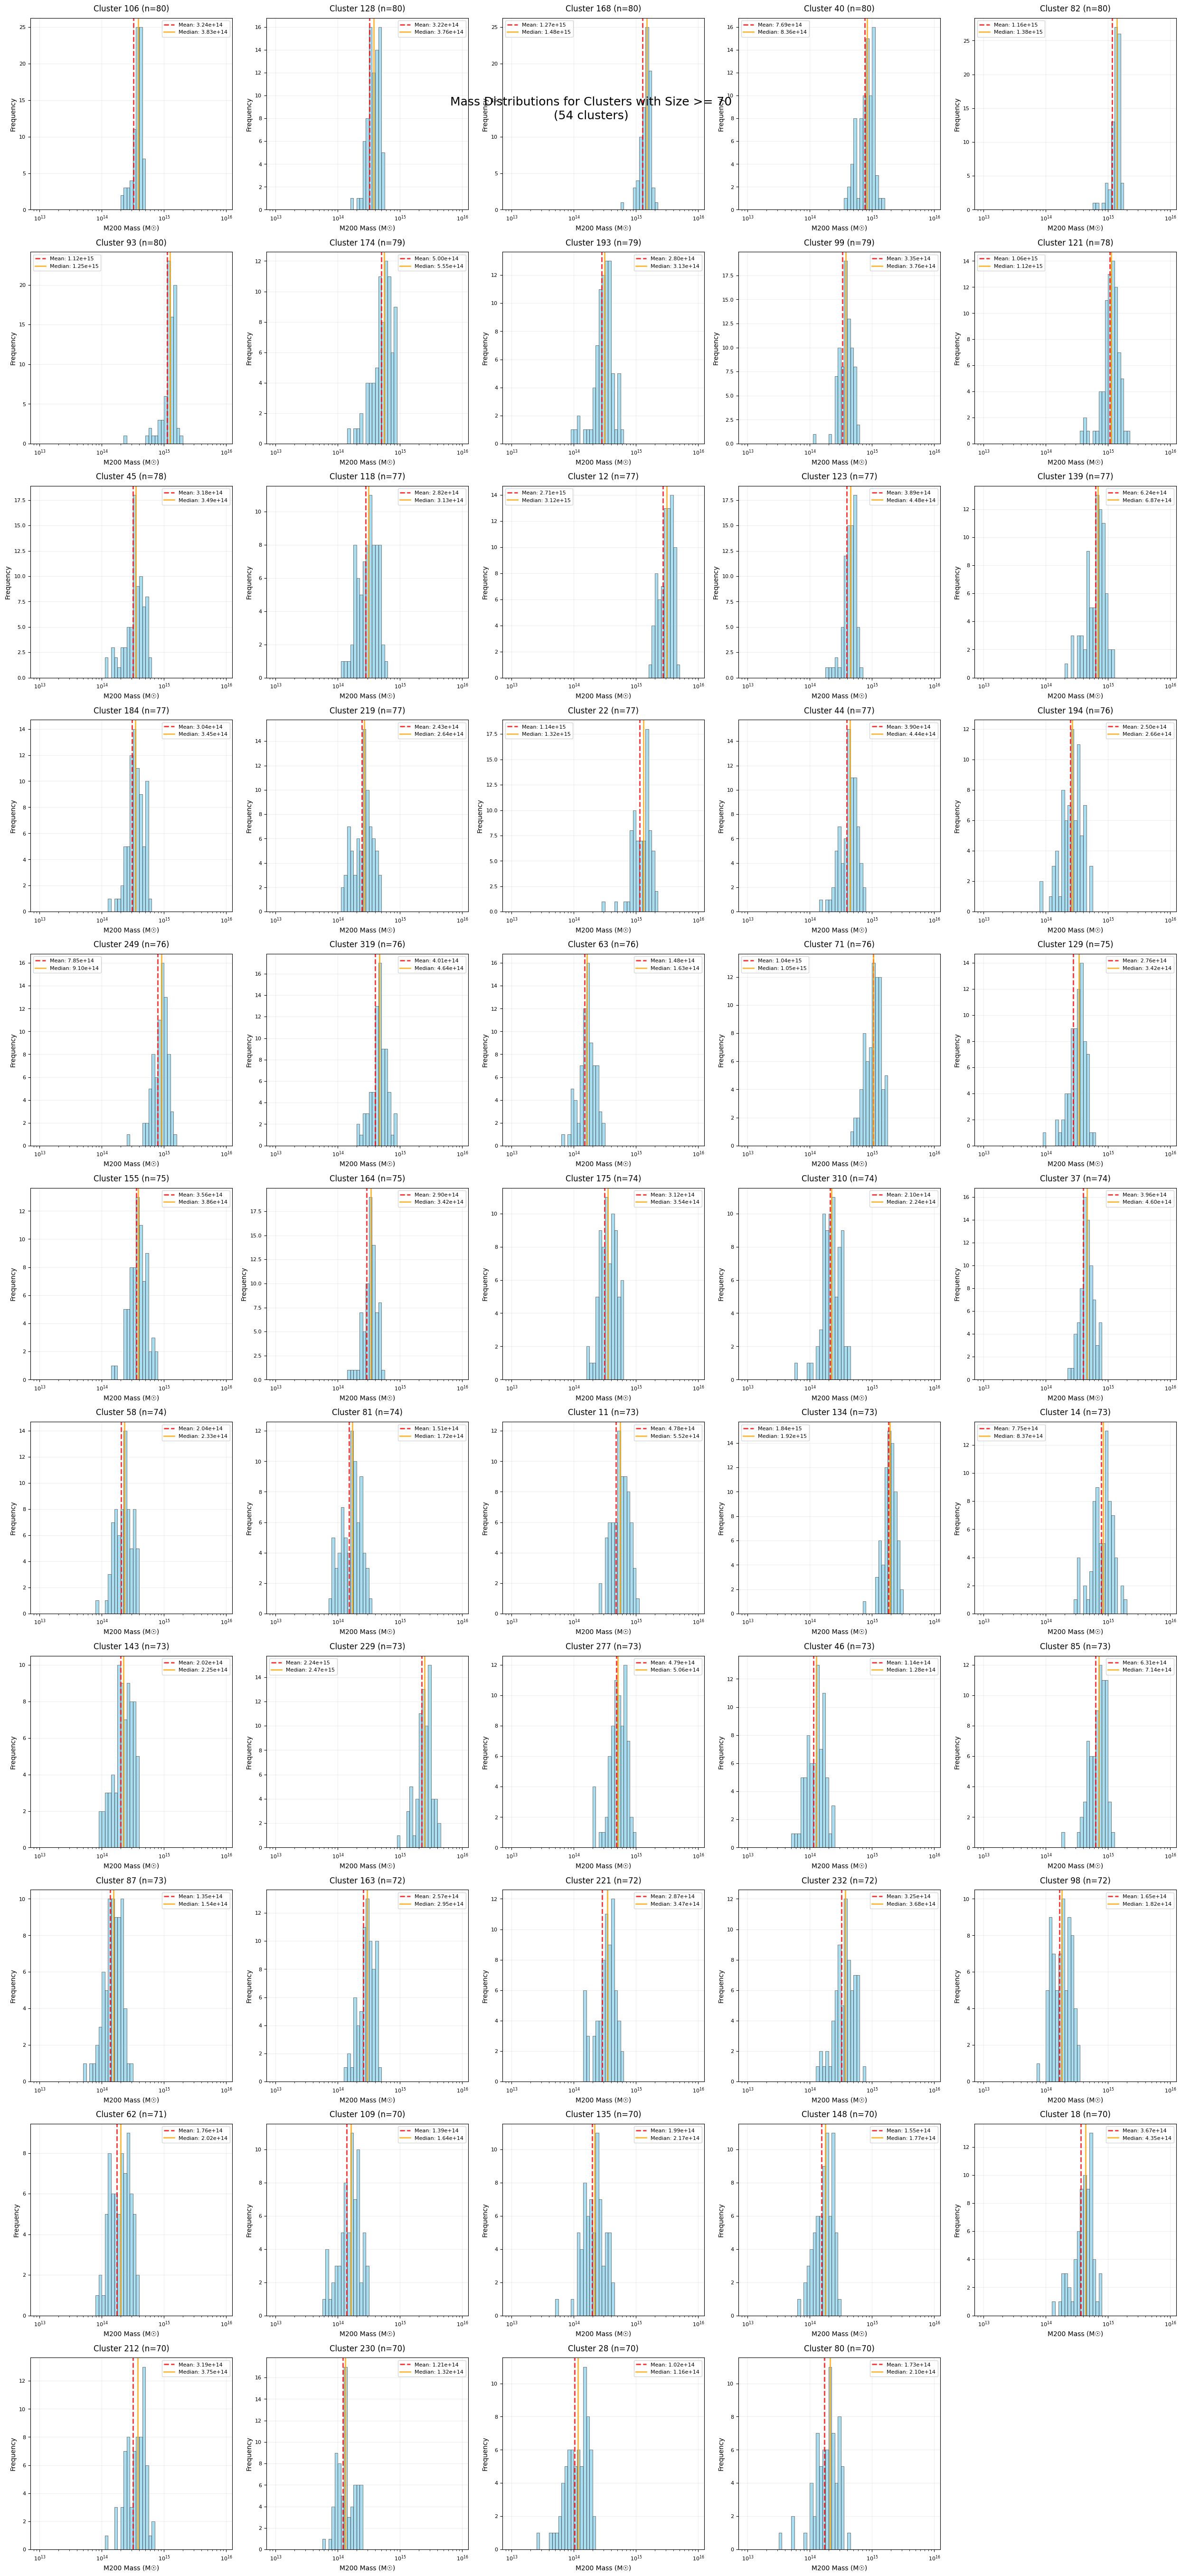

In [62]:
# Cell: Mass Distributions for Clusters Above Size Threshold (5xN Grid)
if clusters_available and len(clusters) > 0:
    # Set cluster size threshold
    cluster_size_threshold = 70  # Adjustable parameter
    
    # Filter clusters by size
    large_clusters = [cluster for cluster in clusters if cluster['cluster_size'] >= cluster_size_threshold]
    
    if len(large_clusters) == 0:
        print(f"No clusters found with size >= {cluster_size_threshold}")
    else:
        # Calculate grid dimensions (5 columns, as many rows as needed)
        n_cols = 5
        n_rows = (len(large_clusters) + n_cols - 1) // n_cols  # Ceiling division
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
        
        # Handle case where there's only one row
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        # Sort by cluster size descending
        large_clusters.sort(key=lambda c: c['cluster_size'], reverse=True)
        
        for plot_idx in range(len(large_clusters)):
            cluster = large_clusters[plot_idx]
            ax = axes[plot_idx]
            plot_cluster_mass_distribution(cluster['cluster_id'], ax=ax)
        
        # Hide unused subplots
        for plot_idx in range(len(large_clusters), n_rows * n_cols):
            axes[plot_idx].set_visible(False)
        
        plt.suptitle(f'Mass Distributions for Clusters with Size >= {cluster_size_threshold}\n({len(large_clusters)} clusters)', fontsize=18, y=0.95)
        plt.tight_layout()
        #plt.subplots_adjust(top=0.92)
        plt.show()

# Inspect individual clusters

In [63]:
cluster_id = 220
plot_cluster_diagnostic(cluster_id=cluster_id)
plot_cluster_mass_distribution(cluster_id=cluster_id)
_ = plot_cluster_trajectory(cluster_id=cluster_id)
plot_cluster_mass_evolution(cluster_id=cluster_id)

Cluster ID 220 not found
Cluster ID 220 not found
No traces available for cluster 220
No traces available for cluster 220


Custom coordinates analysis:
  Center: [460.0, 482.0, 470.0]


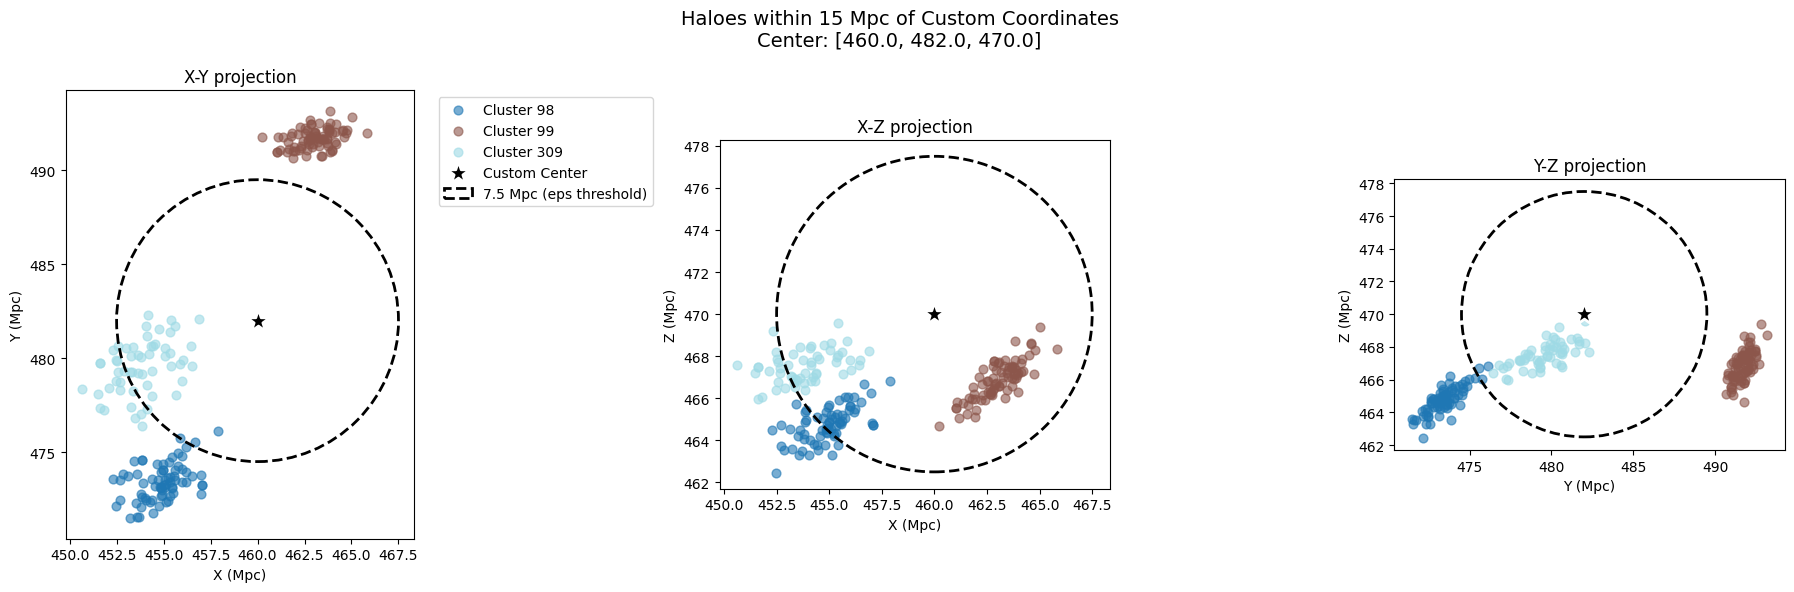

Custom coordinates analysis:
  Center: [550.0, 522.0, 540.0]


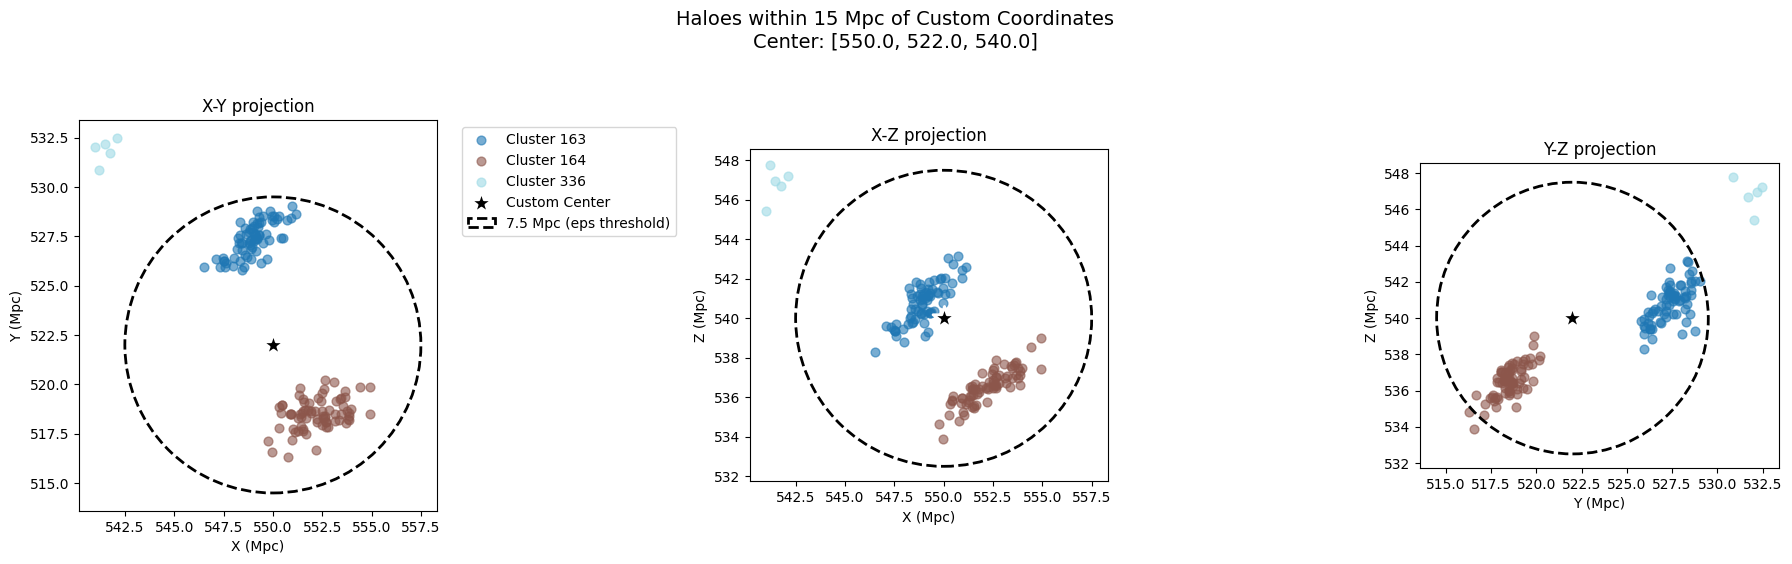

In [64]:
plot_cluster_diagnostic(coordinates=[460, 482, 470])
plot_cluster_diagnostic(coordinates=[550,522,540])

# Save median properties

In [69]:
# Cell: Export Simplified Cluster Data
import h5py
import numpy as np
import os

# Configuration variables
min_cluster_size = 30  # Modify this threshold as needed
output_filename = "simplified_clusters.h5"  # Modify filename as needed

if clusters_available and len(clusters) > 0:
    # Filter clusters by size threshold
    filtered_clusters = [cluster for cluster in clusters if cluster['cluster_size'] >= min_cluster_size]
    
    if len(filtered_clusters) == 0:
        print(f"No clusters found with size >= {min_cluster_size}")
    else:
        print(f"Processing {len(filtered_clusters)} clusters with size >= {min_cluster_size}")
        
        # Get all property keys from first cluster
        property_keys = list(filtered_clusters[0]['member_data'].keys())
        
        # Initialize storage for median values
        cluster_ids = []
        cluster_sizes = []
        median_properties = {}
        
        # Initialize median property arrays
        for key in property_keys:
            sample_data = filtered_clusters[0]['member_data'][key]
            if len(sample_data.shape) == 1:
                # 1D property
                median_properties[key] = []
            elif len(sample_data.shape) == 2 and sample_data.shape[1] == 3:
                # 3D vector property
                median_properties[key] = []
            else:
                # Other multi-dimensional properties
                median_properties[key] = []
        
        # Calculate medians for each cluster
        for cluster in filtered_clusters:
            cluster_ids.append(cluster['cluster_id'])
            cluster_sizes.append(cluster['cluster_size'])
            
            for key in property_keys:
                data = cluster['member_data'][key]
                
                if len(data.shape) == 1:
                    # 1D property - simple median
                    median_val = np.nanmedian(data)
                    median_properties[key].append(median_val)
                elif len(data.shape) == 2 and data.shape[1] == 3:
                    # 3D vector - median per component
                    median_vec = np.nanmedian(data, axis=0)
                    median_properties[key].append(median_vec)
                else:
                    # Other shapes - median along first axis
                    median_val = np.nanmedian(data, axis=0)
                    median_properties[key].append(median_val)
        
        # Convert lists to arrays
        cluster_ids = np.array(cluster_ids)
        cluster_sizes = np.array(cluster_sizes)
        for key in property_keys:
            median_properties[key] = np.array(median_properties[key])
        
        # Save to HDF5
        output_path = os.path.join(config.global_config.output_dir, output_filename)
        
        with h5py.File(output_path, 'w') as f:
            # Metadata
            meta_grp = f.create_group('metadata')
            meta_grp.attrs['threshold_size'] = min_cluster_size
            meta_grp.attrs['n_clusters'] = len(filtered_clusters)
            meta_grp.attrs['source_file'] = 'clusters.h5'
            meta_grp.attrs['total_properties'] = len(property_keys)
            
            # Copy original metadata if available
            if 'cluster_metadata' in locals():
                for key, value in cluster_metadata.items():
                    if isinstance(value, (int, float, str)):
                        meta_grp.attrs[f'original_{key}'] = value
                    elif isinstance(value, (list, np.ndarray)):
                        meta_grp.attrs[f'original_{key}'] = np.array(value)
            
            # Cluster data
            clusters_grp = f.create_group('clusters')
            clusters_grp.create_dataset('cluster_ids', data=cluster_ids)
            clusters_grp.create_dataset('cluster_sizes', data=cluster_sizes)
            
            # Median properties
            median_grp = clusters_grp.create_group('median_properties')
            for key, data in median_properties.items():
                # Convert property name to HDF5-safe format
                dataset_name = key.replace('/', '_')
                median_grp.create_dataset(dataset_name, data=data)
        
        print(f"Saved simplified cluster data to: {output_path}")
        print(f"Properties included: {len(property_keys)}")
        print(f"Sample properties: {property_keys[:5]}{'...' if len(property_keys) > 5 else ''}")
        
        # Summary statistics
        print(f"\nSummary:")
        print(f"  Clusters processed: {len(filtered_clusters)}")
        print(f"  Size range: {np.min(cluster_sizes)} - {np.max(cluster_sizes)}")
        print(f"  Mean cluster size: {np.mean(cluster_sizes):.1f}")
        print(f"  File size: {os.path.getsize(output_path) / 1024**2:.2f} MB")

else:
    print("No cluster data available. Run Mode 1 first.")

Processing 280 clusters with size >= 30
Saved simplified cluster data to: output/simplified_clusters.h5
Properties included: 27
Sample properties: ['BoundSubhalo/CentreOfMass', 'BoundSubhalo/CentreOfMassVelocity', 'BoundSubhalo/EncloseRadius', 'BoundSubhalo/MaximumCircularVelocity', 'BoundSubhalo/TotalMass']...

Summary:
  Clusters processed: 280
  Size range: 30 - 80
  Mean cluster size: 54.7
  File size: 0.08 MB


# Plots for paper

## Looking at individual halo groupings

This demonstrates that the clustering algorithm and choice of hyperparameters are suitable, that distinct halo groupings are identified as suitable clusters.

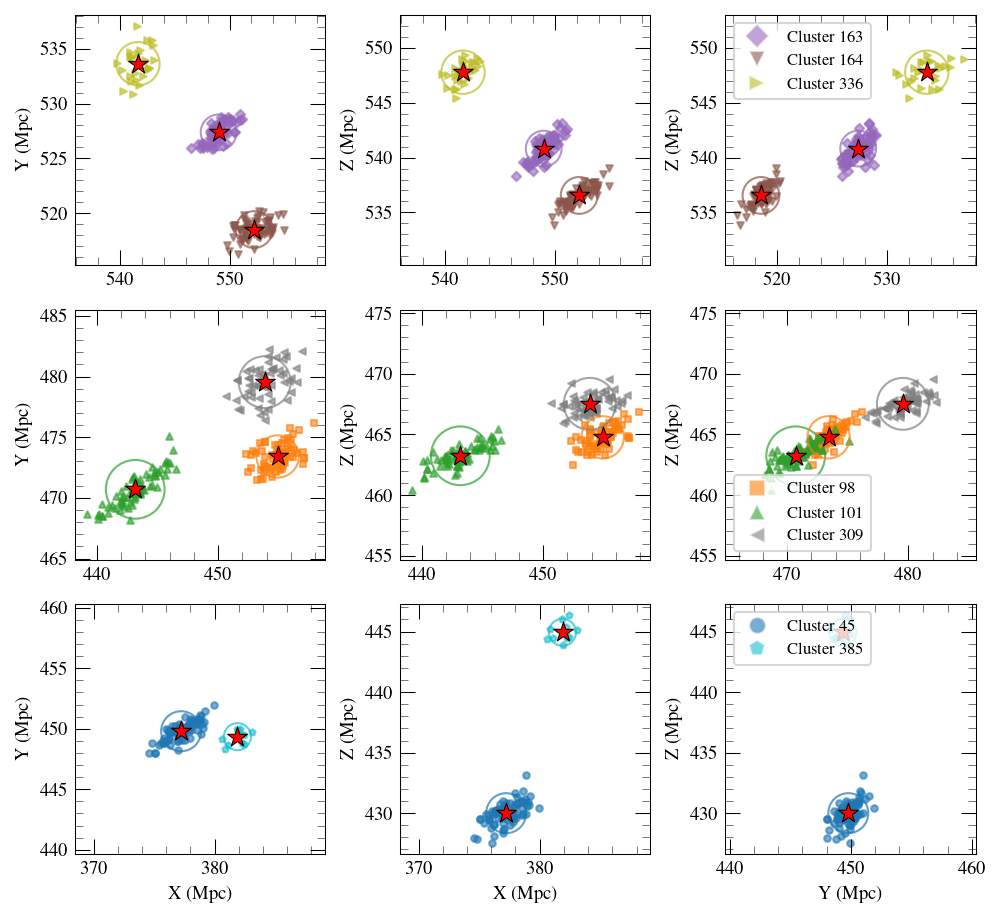

In [75]:
# Cell: Multi-Cluster Diagnostic Plot
def plot_multi_cluster_diagnostic(cluster_ids, window_size=15.0):
  if not clusters_available or len(clusters) == 0:
      print("No clusters available for diagnostic plot")
      return
  
  # Find target clusters
  target_clusters = []
  for cluster_id in cluster_ids:
      target_cluster = None
      for cluster in clusters:
          if cluster['cluster_id'] == cluster_id:
              target_cluster = cluster
              break
      if target_cluster is None:
          print(f"Cluster ID {cluster_id} not found")
          return
      target_clusters.append(target_cluster)
  
  with plt.style.context(get_mplstyle_path(mnras_style)):
      fig, axes = plt.subplots(len(cluster_ids), 3, figsize=(6.5, 6.5))
      if len(cluster_ids) == 1:
          axes = axes.reshape(1, -1)
      
      projections = [
          (0, 1, 'X', 'Y'),
          (0, 2, 'X', 'Z'), 
          (1, 2, 'Y', 'Z')
      ]
      
      symbols = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
      
      # Collect all unique cluster IDs across all rows (only those with centroids in windows)
      all_unique_cluster_ids = set()
      for target_cluster in target_clusters:
          target_cluster_center = target_cluster['mean_position']
          
          # Find clusters whose centroids are within the window
          for cluster in clusters:
              cluster_center = cluster['mean_position']
              distance_to_target = np.linalg.norm(cluster_center - target_cluster_center)
              if distance_to_target <= window_size:
                  all_unique_cluster_ids.add(cluster['cluster_id'])
      
      # Create global color and symbol map for all unique cluster IDs
      all_unique_cluster_ids = sorted(list(all_unique_cluster_ids))
      colors = plt.cm.tab10(np.linspace(0, 1, len(all_unique_cluster_ids)))
      global_color_map = {cluster_id: colors[i] for i, cluster_id in enumerate(all_unique_cluster_ids)}
      global_symbol_map = {cluster_id: symbols[i % len(symbols)] for i, cluster_id in enumerate(all_unique_cluster_ids)}
      
      for row_idx, target_cluster in enumerate(target_clusters):
          target_cluster_center = target_cluster['mean_position']
          target_cluster_id = target_cluster['cluster_id']
          
          # Find clusters whose centroids are within the window
          clusters_in_window = []
          for cluster in clusters:
              cluster_center = cluster['mean_position']
              distance_to_target = np.linalg.norm(cluster_center - target_cluster_center)
              if distance_to_target <= window_size:
                  clusters_in_window.append(cluster)
          
          # Only plot members from clusters whose centroids are in the window
          nearby_positions = []
          nearby_cluster_labels = []
          
          for cluster in clusters_in_window:
              positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
              cluster_id_val = cluster['cluster_id']
              nearby_positions.extend(positions)
              nearby_cluster_labels.extend([cluster_id_val] * len(positions))
          
          nearby_positions = np.array(nearby_positions)
          nearby_cluster_labels = np.array(nearby_cluster_labels)
          
          # Calculate optimized axis limits for this row
          if len(nearby_positions) > 0:
              min_pos = np.min(nearby_positions, axis=0)
              max_pos = np.max(nearby_positions, axis=0)
              ranges = max_pos - min_pos
              centers = (min_pos + max_pos) / 2
              max_range = np.max(ranges)
              padding = max_range * 0.05
          else:
              centers = target_cluster_center
              max_range = 10.0
              padding = 0.5
          
          unique_labels = np.unique(nearby_cluster_labels)
          
          for proj_idx, (dim1, dim2, label1, label2) in enumerate(projections):
              ax = axes[row_idx, proj_idx]
              
              legend_handles = []
              
              for label in unique_labels:
                  mask = nearby_cluster_labels == label
                  color = global_color_map[label]
                  symbol = global_symbol_map[label]
                  scatter = ax.scatter(nearby_positions[mask, dim1], nearby_positions[mask, dim2], 
                            c=[color], s=10, alpha=0.6, marker=symbol)
                  
                  if proj_idx == 2:  # Only create legend entries for first column
                      legend_handles.append(plt.Line2D([0], [0], marker=symbol, color='w', 
                                                     markerfacecolor=color, markersize=8, 
                                                     label=f'Cluster {label}', alpha=0.6))
              
              # Plot cluster centroids and annotations
              for cluster in clusters_in_window:
                  cluster_center = cluster['mean_position']
                  cluster_id_val = cluster['cluster_id']
                  color = global_color_map[cluster_id_val]
                  
                  # Mark centroid
                  ax.scatter(cluster_center[dim1], cluster_center[dim2], 
                            c='red', s=100, marker='*', edgecolors='black', linewidth=0.5)
                  
                  # Add position std circle around centroid
                  position_std = np.linalg.norm(cluster['position_std'])
                  circle = plt.Circle((cluster_center[dim1], cluster_center[dim2]), 
                                     position_std, fill=False, color=color, linestyle='-', linewidth=1, alpha=0.7)
                  ax.add_patch(circle)

              if row_idx == len(cluster_ids) - 1:
                  ax.set_xlabel(f'{label1} (Mpc)')
              ax.set_ylabel(f'{label2} (Mpc)')
              ax.set_aspect('equal')
              
              # Set optimized square axis limits
              center_2d = centers[[dim1, dim2]]
              half_range = max_range / 2 + padding
              ax.set_xlim(center_2d[0] - half_range, center_2d[0] + half_range)
              ax.set_ylim(center_2d[1] - half_range, center_2d[1] + half_range)
              
              # Add legend only to first column
              if proj_idx == 2 and legend_handles:
                  loc = "lower left" if row_idx == 1 else "upper left"
                  ax.legend(handles=legend_handles, loc=loc, fontsize=8)
              
              # Add cluster info text in bottom right of third column
              if proj_idx == 2 and False:
                  target_color = global_color_map[target_cluster_id]
                  info_text = f"ID: {target_cluster_id}\n"
                  info_text += f"Mass: {target_cluster['mean_mass']:.2e} \n"
                  info_text += f"Members: {target_cluster['cluster_size']}"

                  xtext = 0.53 if row_idx == 1 else 0.96
                  ytext = 0.73 if row_idx == 1 else 0.04
                  
                  ax.text(xtext, ytext, info_text, 
                         transform=ax.transAxes, 
                         fontsize=9, 
                         color=target_color, 
                         fontweight='bold',
                         ha='right', va='bottom',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
      
      plt.tight_layout(pad=0.1)
      plt.subplots_adjust(hspace=-0.15, wspace=0.3)
      plt.savefig("./plots/example_halo_groupings.pdf")
      plt.show()

# Example usage
cluster_ids_to_plot = [163,98,45]
plot_multi_cluster_diagnostic(cluster_ids_to_plot, window_size=20)

<>:60: SyntaxWarning: invalid escape sequence '\o'
<>:60: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2538205/642263066.py:60: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('Mean Halo Mass in Grouping [M$_{\odot}$]')


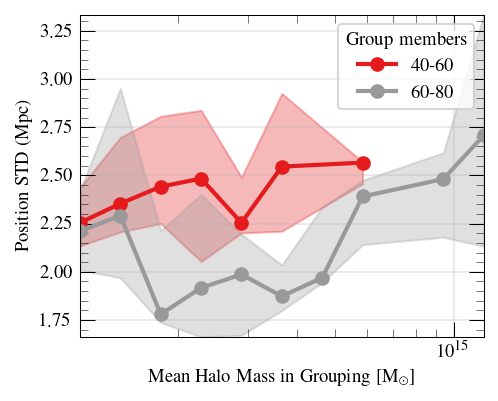

In [72]:
# Cell: Cluster Position Std vs Mean Mass with Custom Size Bins
def plot_position_std_vs_mass(size_bin_edges):
   if not clusters_available or len(clusters) == 0:
       print("No clusters available")
       return
   
   cluster_masses = np.array([cluster['mean_m200_mass'] for cluster in clusters])
   position_stds = np.array([np.linalg.norm(cluster['position_std']) for cluster in clusters])
   cluster_sizes = np.array([cluster['cluster_size'] for cluster in clusters])
   
   # Create masks for size bins using bin edges
   masks = []
   labels = []
   for i in range(len(size_bin_edges) - 1):
       mask = (cluster_sizes >= size_bin_edges[i]) & (cluster_sizes < size_bin_edges[i+1])
       labels.append(f'{size_bin_edges[i]}-{size_bin_edges[i+1]}')
       masks.append(mask)
   
   colors = plt.cm.Set1(np.linspace(0, 1, len(masks)))

   with plt.style.context(get_mplstyle_path(mnras_style)):
       fig, ax = plt.subplots(figsize=(3.15, 2.5))
       
       # Create log-spaced mass bins
       mass_bins = np.logspace(np.log10(cluster_masses.min()), np.log10(cluster_masses.max()), 15)
       
       for i, (mask, label, color) in enumerate(zip(masks, labels, colors)):
           if np.sum(mask) == 0:
               continue
               
           masses_subset = cluster_masses[mask]
           stds_subset = position_stds[mask]
           
           # Bin the data
           bin_indices = np.digitize(masses_subset, mass_bins)
           
           medians = []
           p25 = []
           p75 = []
           bin_centers = []
           
           for j in range(1, len(mass_bins)):
               bin_mask = bin_indices == j
               if np.sum(bin_mask) >= 3:  # Need at least 3 points for statistics
                   bin_stds = stds_subset[bin_mask]
                   medians.append(np.median(bin_stds))
                   p25.append(np.percentile(bin_stds, 25))
                   p75.append(np.percentile(bin_stds, 75))
                   bin_centers.append(np.sqrt(mass_bins[j-1] * mass_bins[j]))
           
           if len(medians) > 0:
               bin_centers = np.array(bin_centers)
               medians = np.array(medians)
               p25 = np.array(p25)
               p75 = np.array(p75)
               
               ax.plot(bin_centers, medians, '-o', color=color, label=label, linewidth=2, markersize=6)
               ax.fill_between(bin_centers, p25, p75, color=color, alpha=0.3)
       
       ax.set_xlabel('Mean Halo Mass in Grouping [M$_{\odot}$]')
       ax.set_ylabel('Position STD (Mpc)')
       ax.set_xscale('log')
       ax.grid(True, alpha=0.3)
       ax.legend(title="Group members")
       
       plt.tight_layout(pad=0.1)
       plt.savefig("./plots/position_std_vs_mass.pdf")
       plt.show()

# Example usage
size_bin_edges = [40, 60, 80]
plot_position_std_vs_mass(size_bin_edges)